In [194]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%precision 3


'%.3f'

In [195]:
pro = ts.pro_api('')


In [196]:
def SMA(df,  short_term_days, long_term_days):
    # sort by date
    df['trade_date'] = pd.to_datetime(df['trade_date']).dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['trade_date'])
    df = df.sort_values(by='date')

    # short term
    SMA_short = pd.DataFrame()
    SMA_short['close'] = df['close'].rolling(window=short_term_days).mean()

    # long term
    SMA_long = pd.DataFrame()
    SMA_long['close'] = df['close'].rolling(window=long_term_days).mean()

    data = pd.DataFrame()
    data['trade_date'] = df['trade_date']
    data['close'] = df['close']
    data['SMA_short'] = SMA_short['close']
    data['SMA_long'] = SMA_long['close']
    data['date'] = pd.to_datetime(df['trade_date'])

    data.set_index(['date'], inplace=True)

    return data

In [197]:
# Double SMA Crossing Strategy
def buy_sell(data):
    sig_price_buy = []
    sig_price_sell = []
    flag = -1

    for i in range(len(data)):
        if data['SMA_short'][i] > data['SMA_long'][i]:
            if flag != 1:
                sig_price_buy.append(data['close'][i])
                sig_price_sell.append(np.nan)
                flag = 1
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        elif data['SMA_short'][i] < data['SMA_long'][i]:
            if flag != 0:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(data['close'][i])
                flag = 0
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        else:
            sig_price_buy.append(np.nan)
            sig_price_sell.append(np.nan)
    return (sig_price_buy, sig_price_sell)


In [198]:
# date and buy_sell signal
def dates(data):
    buy_dates = pd.DataFrame(data.loc[data['buy_signal_price'] > 0])
    sell_dates = pd.DataFrame(data.loc[data['sell_signal_price'] > 0])
    buy_dates.drop(columns=['sell_signal_price',
                            'SMA_short', 'SMA_long'], inplace=True)
    sell_dates.drop(columns=['buy_signal_price',
                             'SMA_short', 'SMA_long'], inplace=True)

    dates = pd.concat([buy_dates, sell_dates], sort=True)
    
    dates.sort_values(by='trade_date', inplace=True, ascending=False)
    dates.drop(
        columns=['close'], inplace=True)

    print(dates)
    return dates


In [199]:
# drawing graph
def graph(data, code, short_term_days, long_term_days):
    ab = plt.figure(figsize=[40, 12])

    plt.plot(data['close'], label='PMAC', alpha=0.35)
    plt.plot(data['SMA_short'], label='SMA_' + str(short_term_days), alpha=0.7)
    plt.plot(data['SMA_long'], label='SMA_' + str(long_term_days), alpha=0.7)
    plt.scatter(data.index, data['buy_signal_price'],
                label='Buy', marker='^', color='green')
    plt.scatter(data.index, data['sell_signal_price'],
                label='Sell', marker='v', color='red')

    plt.title('{} close price hsitory buy and cell signals'.format(code))
    plt.xlabel(
        '{} - {}'.format(data['trade_date'].iloc[0],  data['trade_date'].iloc[-1]))
    plt.ylabel('Close price RMB')
    plt.legend()
    plt.show()


In [200]:
# get the accumulated earnings
def earnings_buy_sell_same_shares_when_signal_shown(buy_sell_dates, shares):
    earnings = 0

    for i in range(len(buy_sell_dates)):
        if np.isnan(buy_sell_dates['buy_signal_price'][i]):
            earnings += buy_sell_dates['sell_signal_price'][i] * shares

        if np.isnan(buy_sell_dates['sell_signal_price'][i]):
            earnings -= buy_sell_dates['buy_signal_price'][i] * shares

    # df[(~(df['buy_signal_price'].isnull())) |
    #     (~(df['sell_signal_price'].isnull()))]
    return str(earnings / 100) + '%'


In [201]:
def graph_chart(stock_data, name, code, short_term_days, long_term_days):
    data = SMA(stock_data, short_term_days, long_term_days)
    buy_sell_data = buy_sell(data)
    data['buy_signal_price'] = buy_sell_data[0]
    data['sell_signal_price'] = buy_sell_data[1]

    graph(data, code, short_term_days, long_term_days)

    buy_sell_dates = dates(data)
    print(name + ' ' + code)
    print('short_term_days: ' + str(short_term_days),
          'long_term_days: ' + str(long_term_days))
    return earnings_buy_sell_same_shares_when_signal_shown(buy_sell_dates, 100)


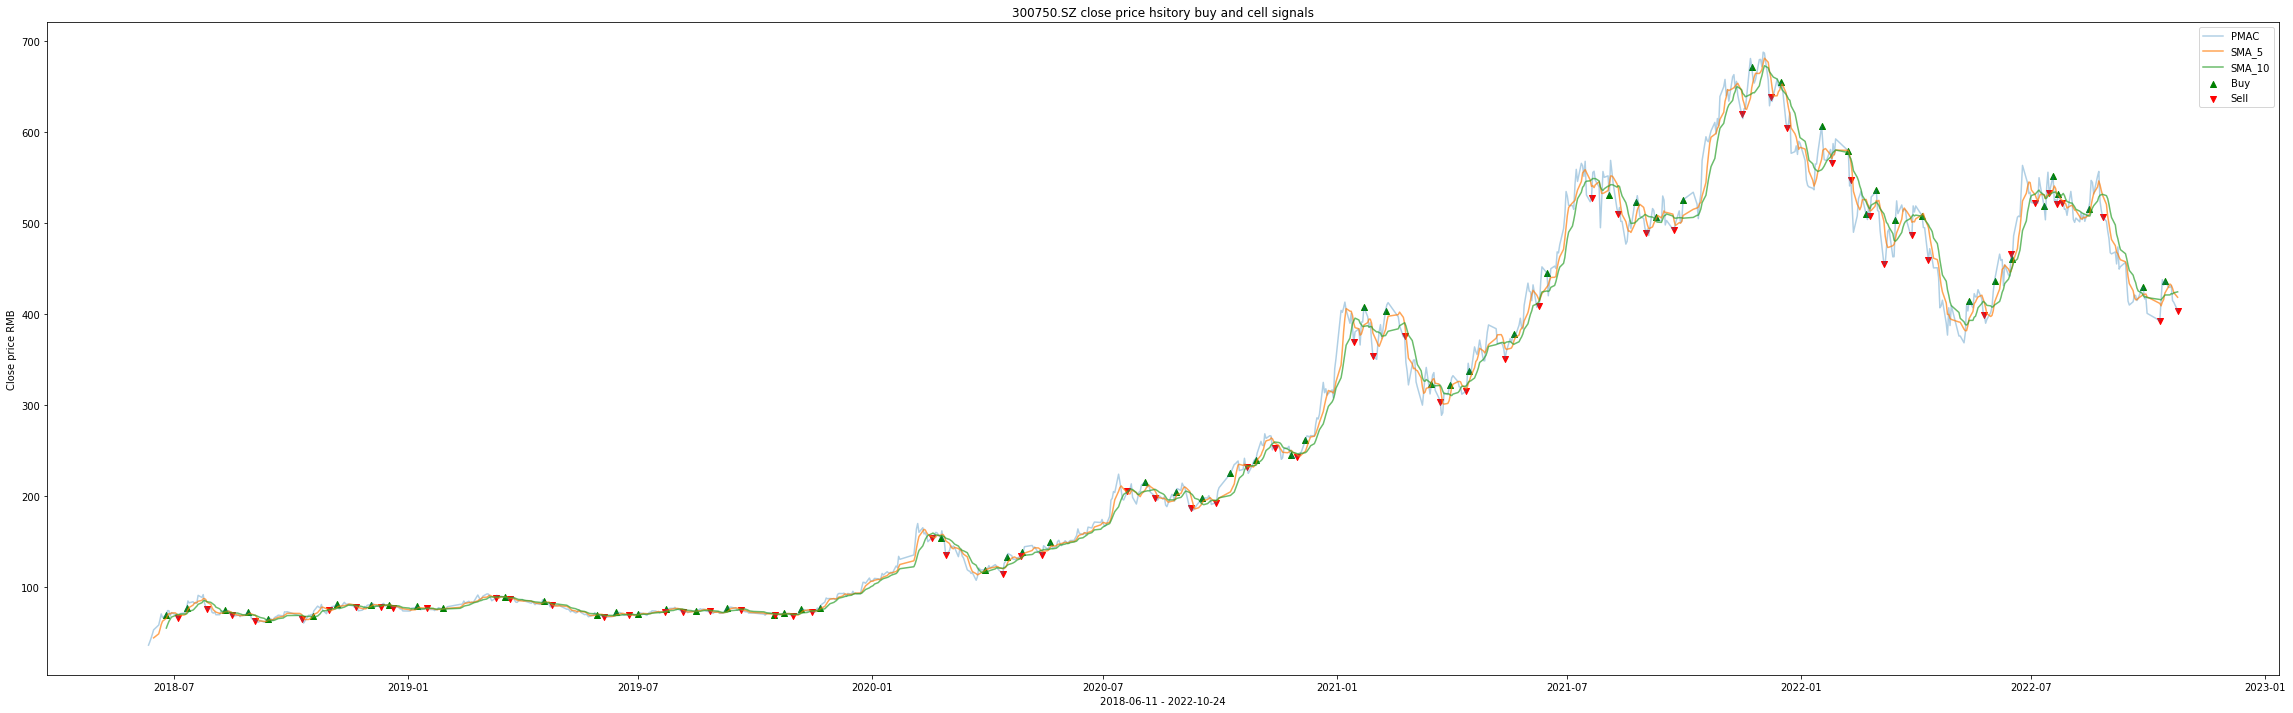

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-24               NaN             404.02  2022-10-24
2022-10-14            436.91                NaN  2022-10-14
2022-10-10               NaN             392.86  2022-10-10
2022-09-27            429.50                NaN  2022-09-27
2022-08-26               NaN             506.78  2022-08-26
...                      ...                ...         ...
2018-08-10             74.44                NaN  2018-08-10
2018-07-27               NaN              76.05  2018-07-27
2018-07-11             77.06                NaN  2018-07-11
2018-07-04               NaN              65.92  2018-07-04
2018-06-25             69.19                NaN  2018-06-25

[126 rows x 3 columns]
宁德时代 300750.SZ
short_term_days: 5 long_term_days: 10
earnings: -133.12999999999974%
data length: 1061


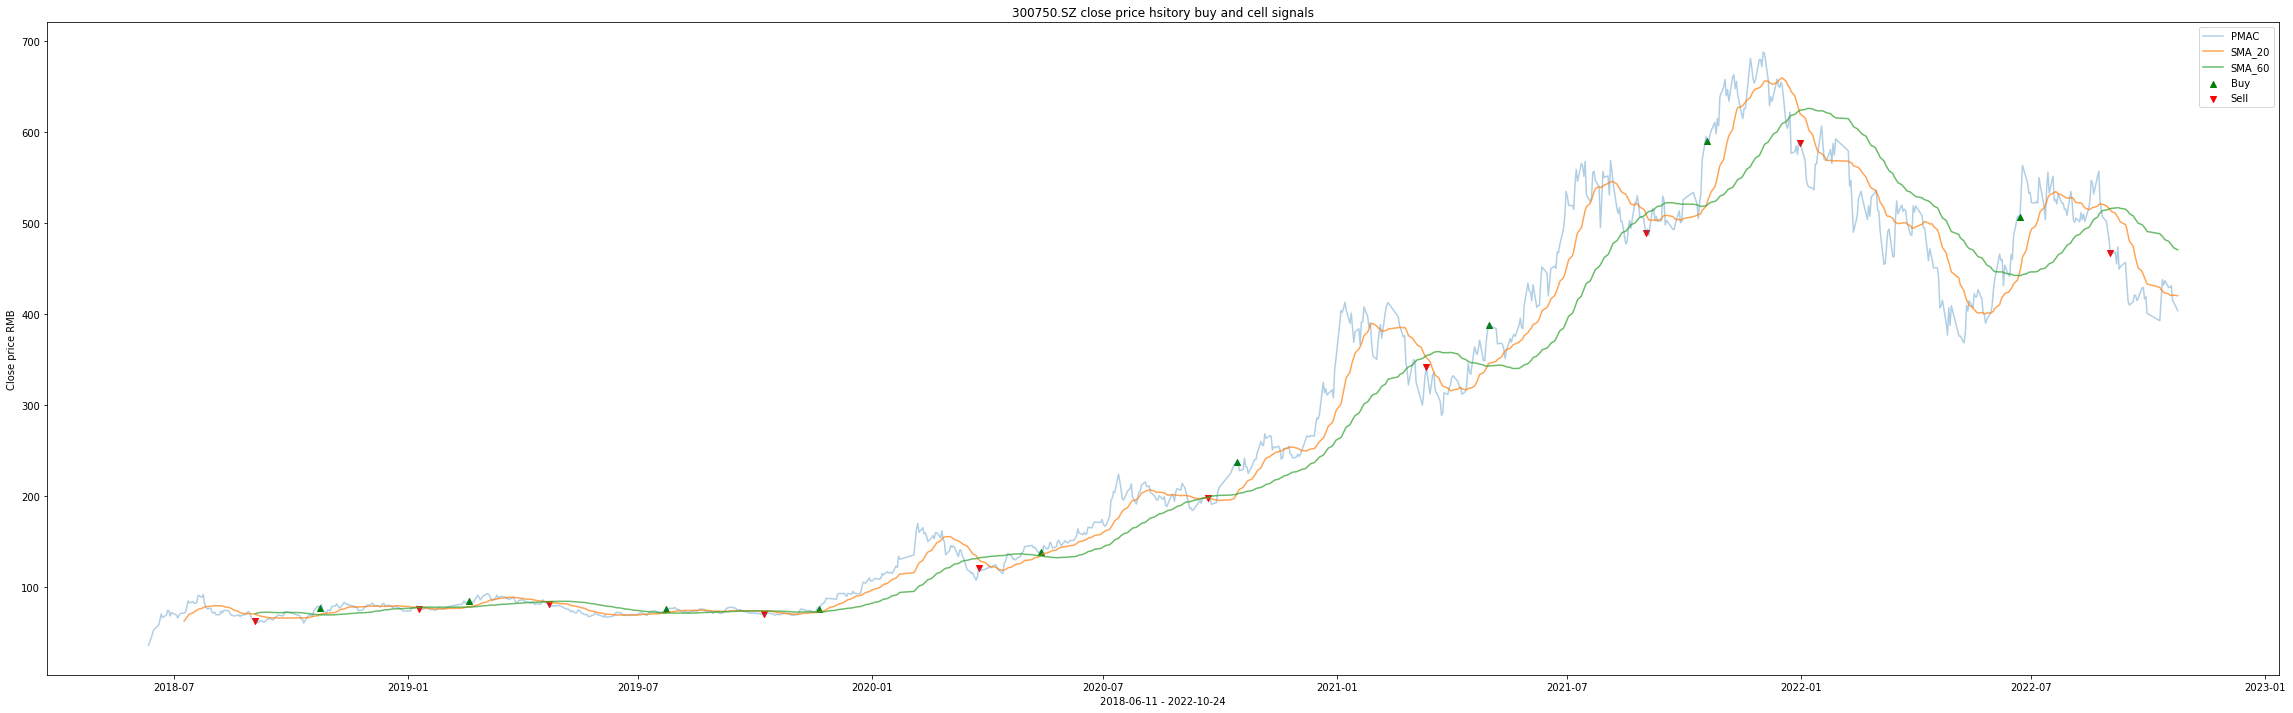

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-09-01               NaN             467.54  2022-09-01
2022-06-22            507.00                NaN  2022-06-22
2021-12-31               NaN             588.00  2021-12-31
2021-10-19            590.60                NaN  2021-10-19
2021-09-01               NaN             488.71  2021-09-01
2021-04-30            388.17                NaN  2021-04-30
2021-03-12               NaN             341.46  2021-03-12
2020-10-14            237.30                NaN  2020-10-14
2020-09-21               NaN             197.93  2020-09-21
2020-05-13            138.26                NaN  2020-05-13
2020-03-25               NaN             121.00  2020-03-25
2019-11-20             76.30                NaN  2019-11-20
2019-10-08               NaN              70.26  2019-10-08
2019-07-23             75.87                NaN  2019-07-23
2019-04-22               NaN            

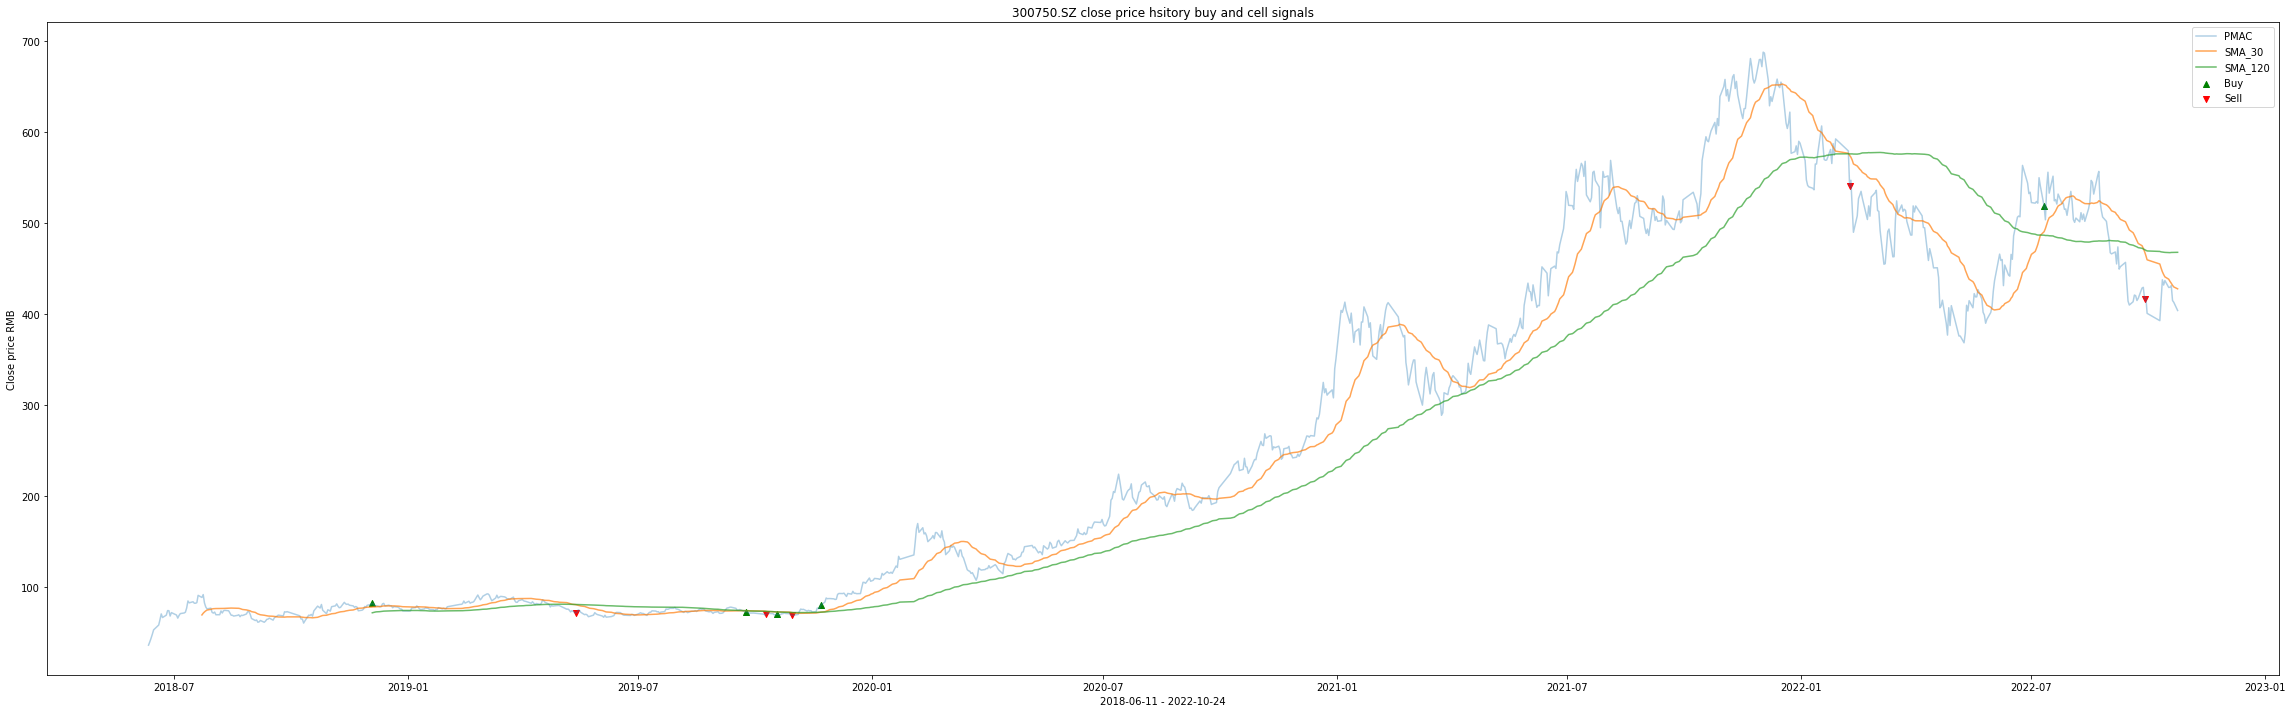

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-09-28               NaN             416.79  2022-09-28
2022-07-11            518.50                NaN  2022-07-11
2022-02-08               NaN             540.86  2022-02-08
2019-11-22             80.50                NaN  2019-11-22
2019-10-30               NaN              69.52  2019-10-30
2019-10-18             70.09                NaN  2019-10-18
2019-10-10               NaN              70.90  2019-10-10
2019-09-24             72.73                NaN  2019-09-24
2019-05-13               NaN              71.59  2019-05-13
2018-12-04             82.30                NaN  2018-12-04
宁德时代 300750.SZ
short_term_days: 30 long_term_days: 120
earnings: 345.54%
data length: 1061


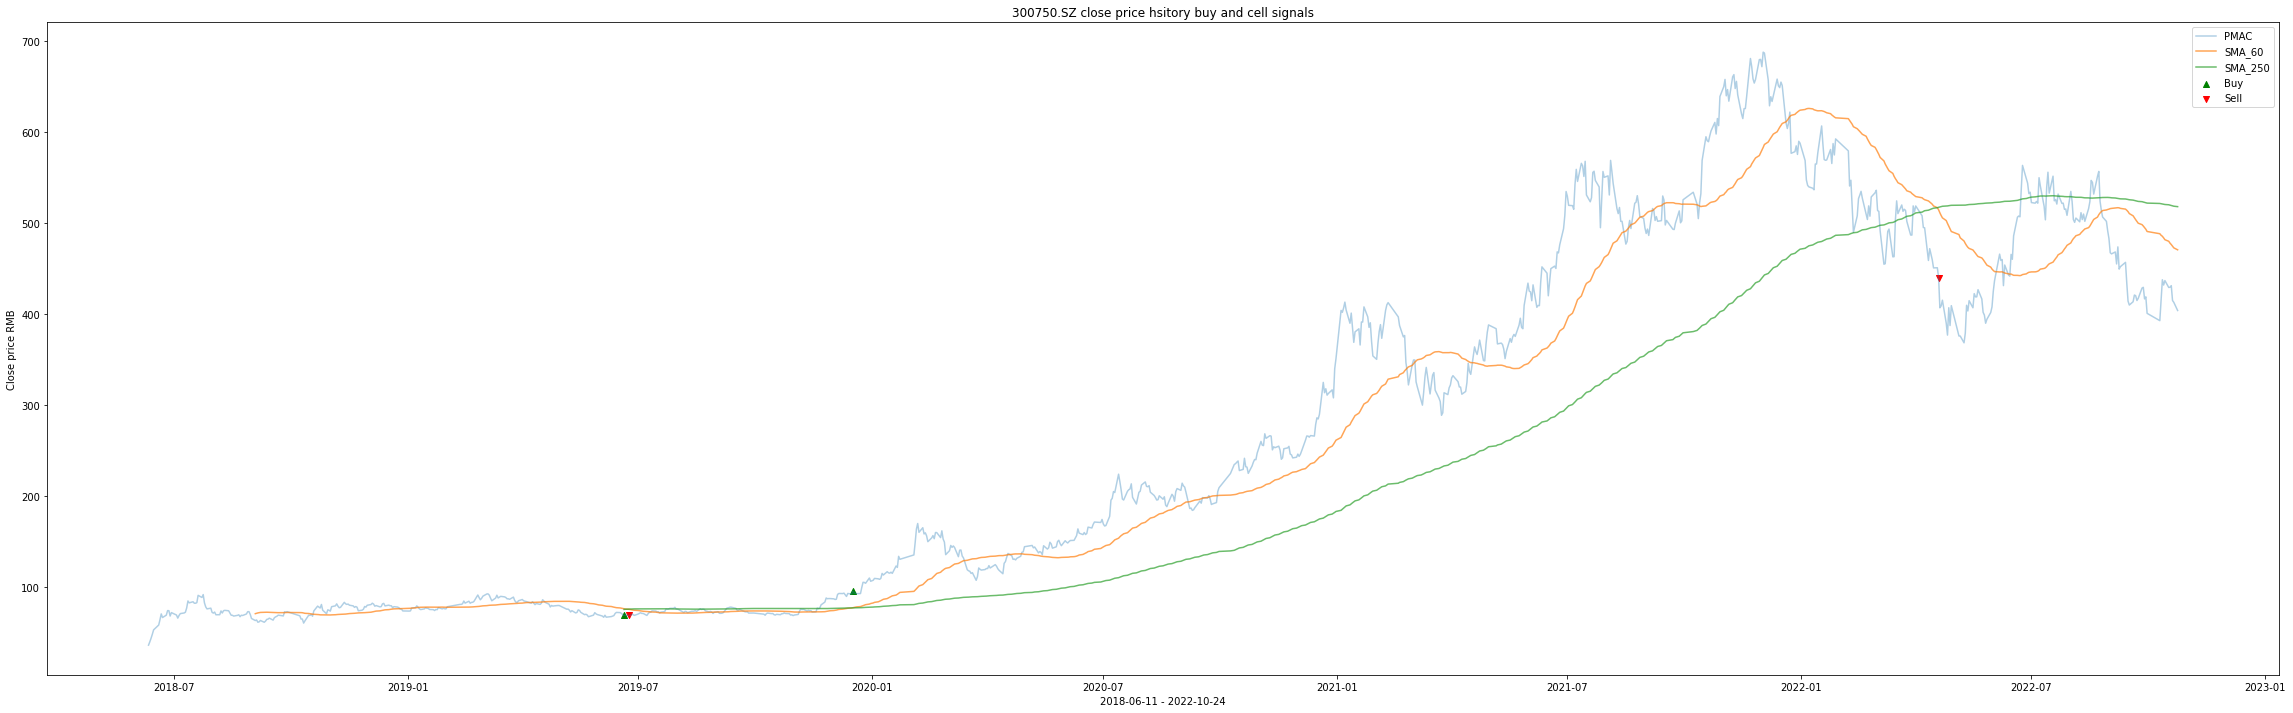

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-04-19               NaN             440.26  2022-04-19
2019-12-17             95.39                NaN  2019-12-17
2019-06-24               NaN              68.86  2019-06-24
2019-06-20             69.06                NaN  2019-06-20
宁德时代 300750.SZ
short_term_days: 60 long_term_days: 250
earnings: 344.67%
data length: 1061


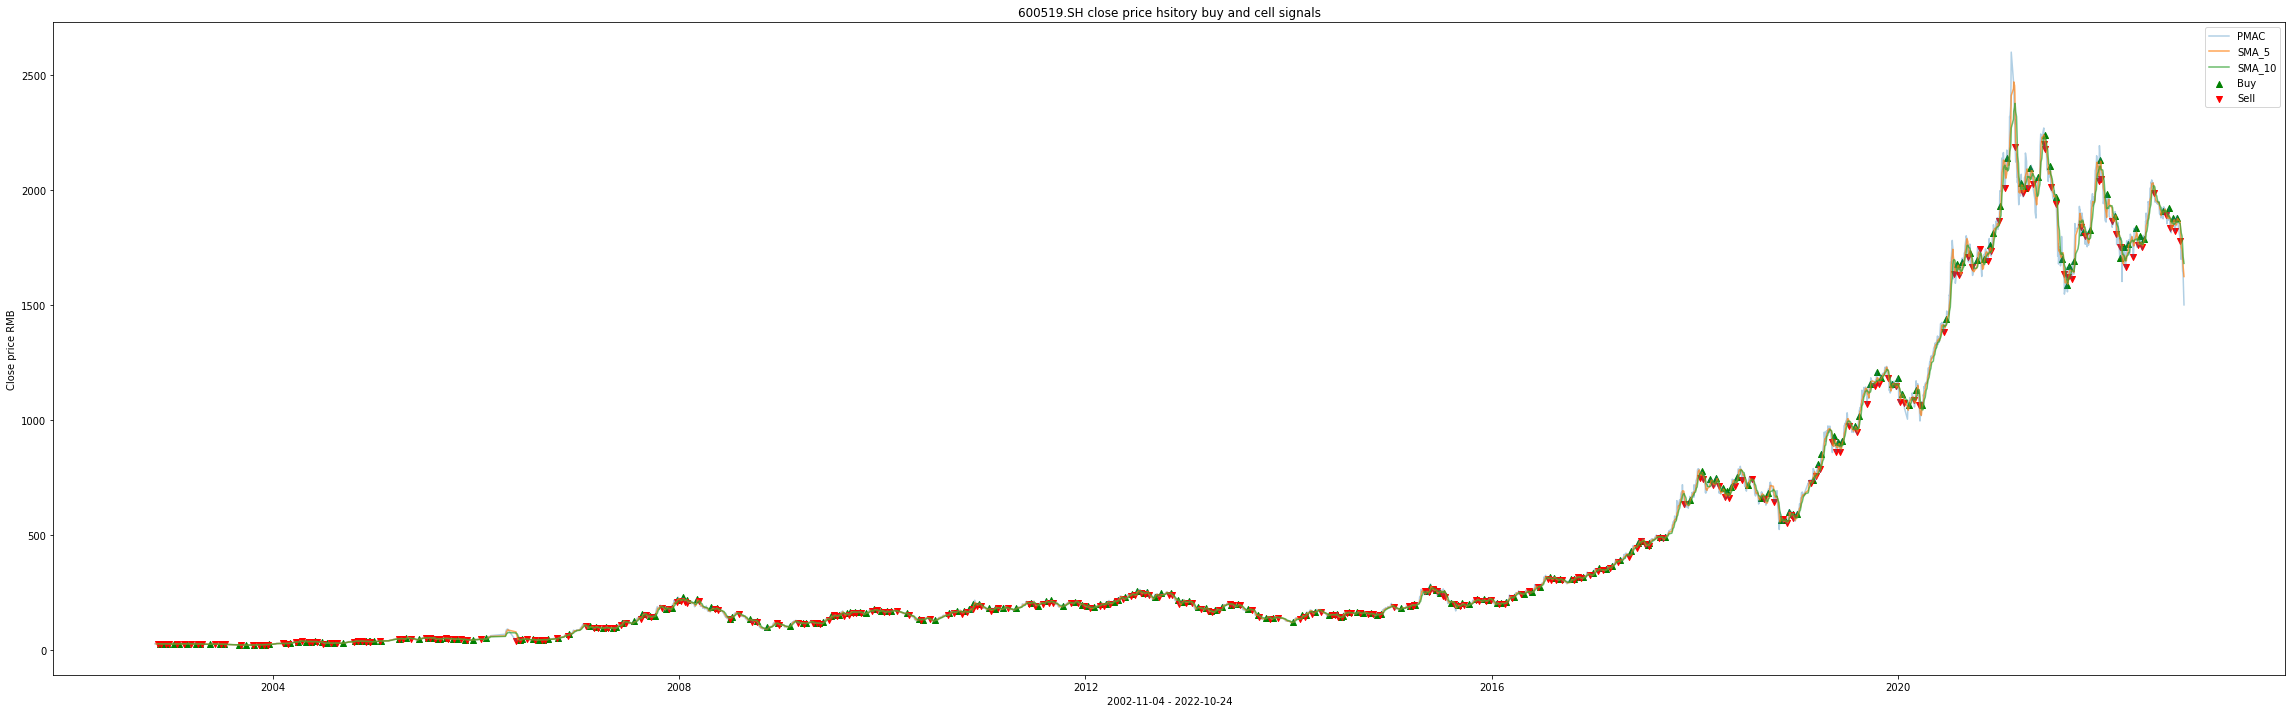

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-11               NaN            1779.99  2022-10-11
2022-09-29           1880.35                NaN  2022-09-29
2022-09-22               NaN            1820.81  2022-09-22
2022-09-15           1880.00                NaN  2022-09-15
2022-09-05               NaN            1835.00  2022-09-05
...                      ...                ...         ...
2002-12-13               NaN              26.49  2002-12-13
2002-12-04             26.45                NaN  2002-12-04
2002-11-26               NaN              25.71  2002-11-26
2002-11-21             25.86                NaN  2002-11-21
2002-11-15               NaN              25.82  2002-11-15

[547 rows x 3 columns]
贵州茅台 600519.SH
short_term_days: 5 long_term_days: 10
earnings: 189.83999999999926%
data length: 4779


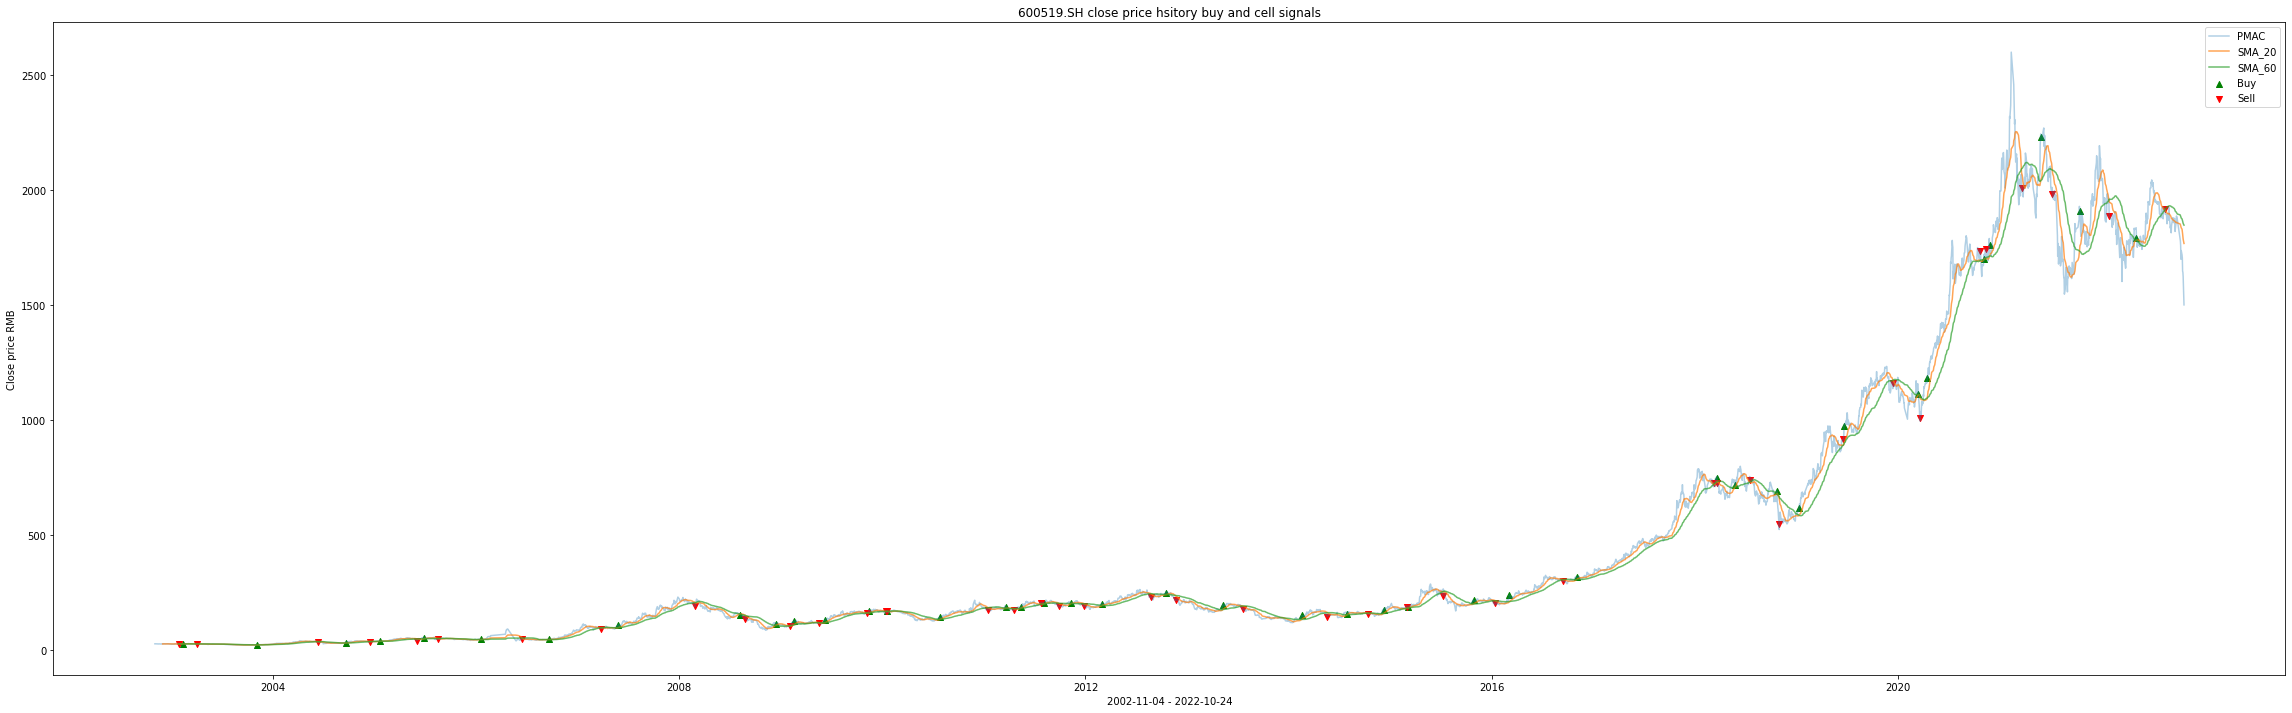

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-08-17               NaN            1918.00  2022-08-17
2022-05-06           1793.00                NaN  2022-05-06
2022-01-28               NaN            1887.00  2022-01-28
2021-10-14           1911.00                NaN  2021-10-14
2021-07-08               NaN            1985.00  2021-07-08
...                      ...                ...         ...
2004-06-11               NaN              34.51  2004-06-11
2003-11-05             23.58                NaN  2003-11-05
2003-04-04               NaN              26.03  2003-04-04
2003-02-12             26.88                NaN  2003-02-12
2003-01-28               NaN              26.84  2003-01-28

[83 rows x 3 columns]
贵州茅台 600519.SH
short_term_days: 20 long_term_days: 60
earnings: 1598.19%
data length: 4779


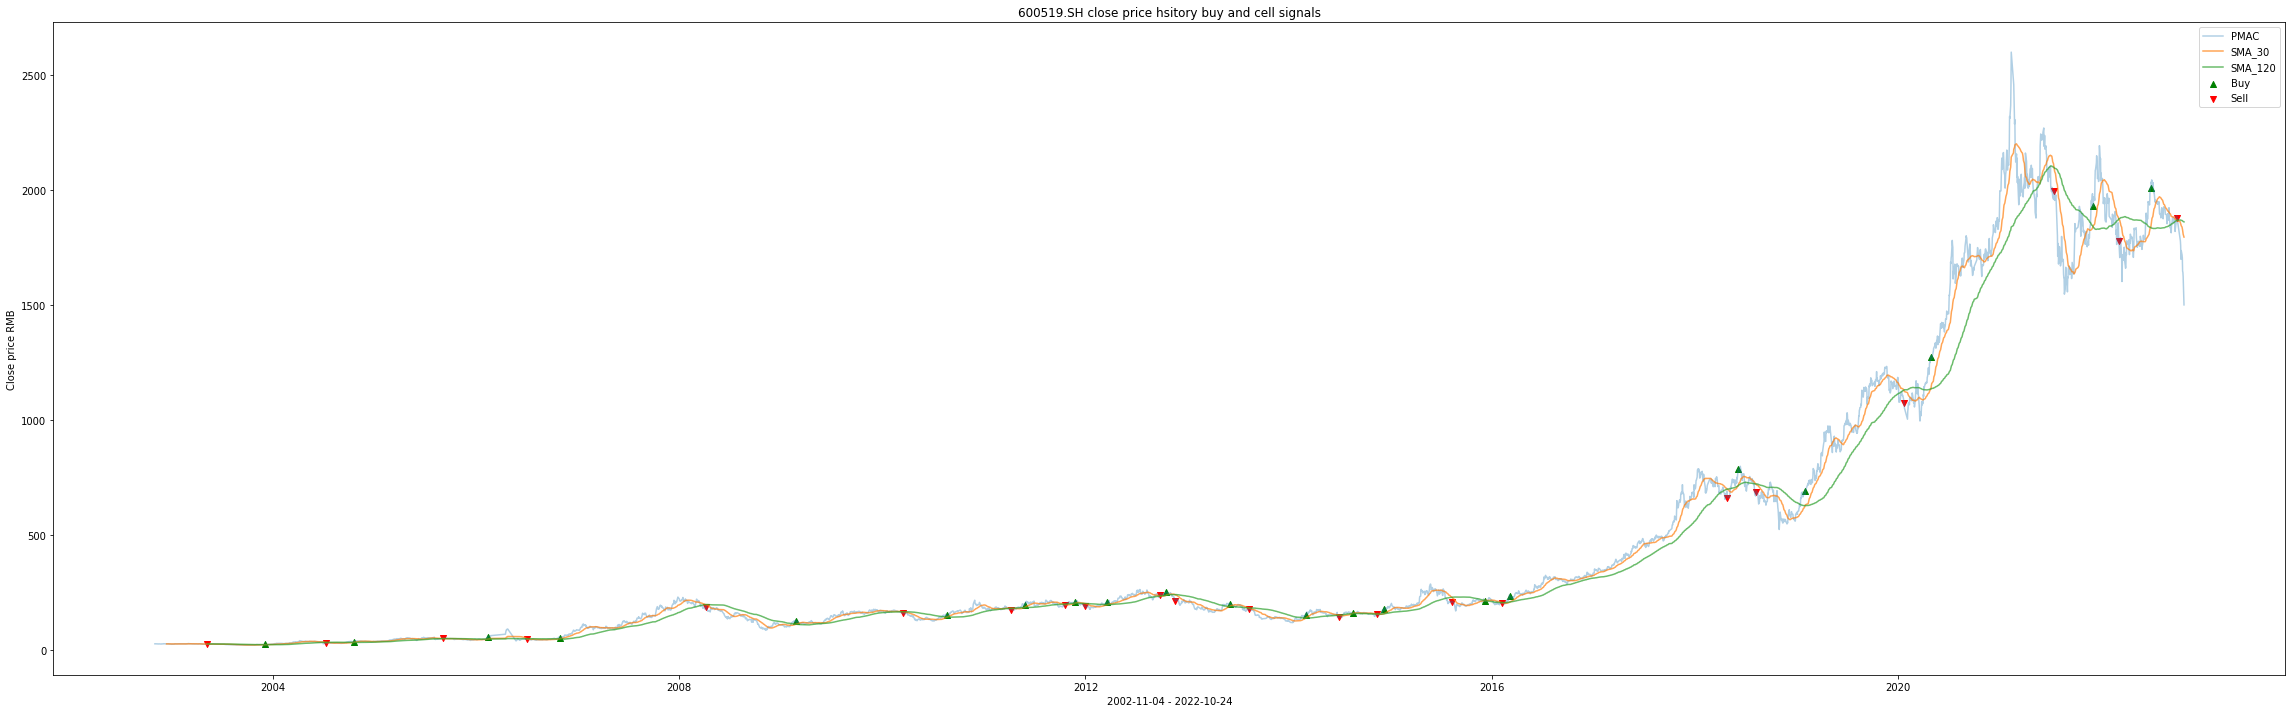

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-09-29               NaN            1880.35  2022-09-29
2022-06-27           2010.55                NaN  2022-06-27
2022-03-04               NaN            1780.50  2022-03-04
2021-12-01           1932.99                NaN  2021-12-01
2021-07-15               NaN            1997.99  2021-07-15
2020-04-27           1276.00                NaN  2020-04-27
2020-01-22               NaN            1075.51  2020-01-22
2019-02-01            692.67                NaN  2019-02-01
2018-08-07               NaN             686.28  2018-08-07
2018-06-05            788.05                NaN  2018-06-05
2018-04-27               NaN             662.53  2018-04-27
2016-03-07            233.64                NaN  2016-03-07
2016-02-05               NaN             203.87  2016-02-05
2015-12-09            214.47                NaN  2015-12-09
2015-08-11               NaN            

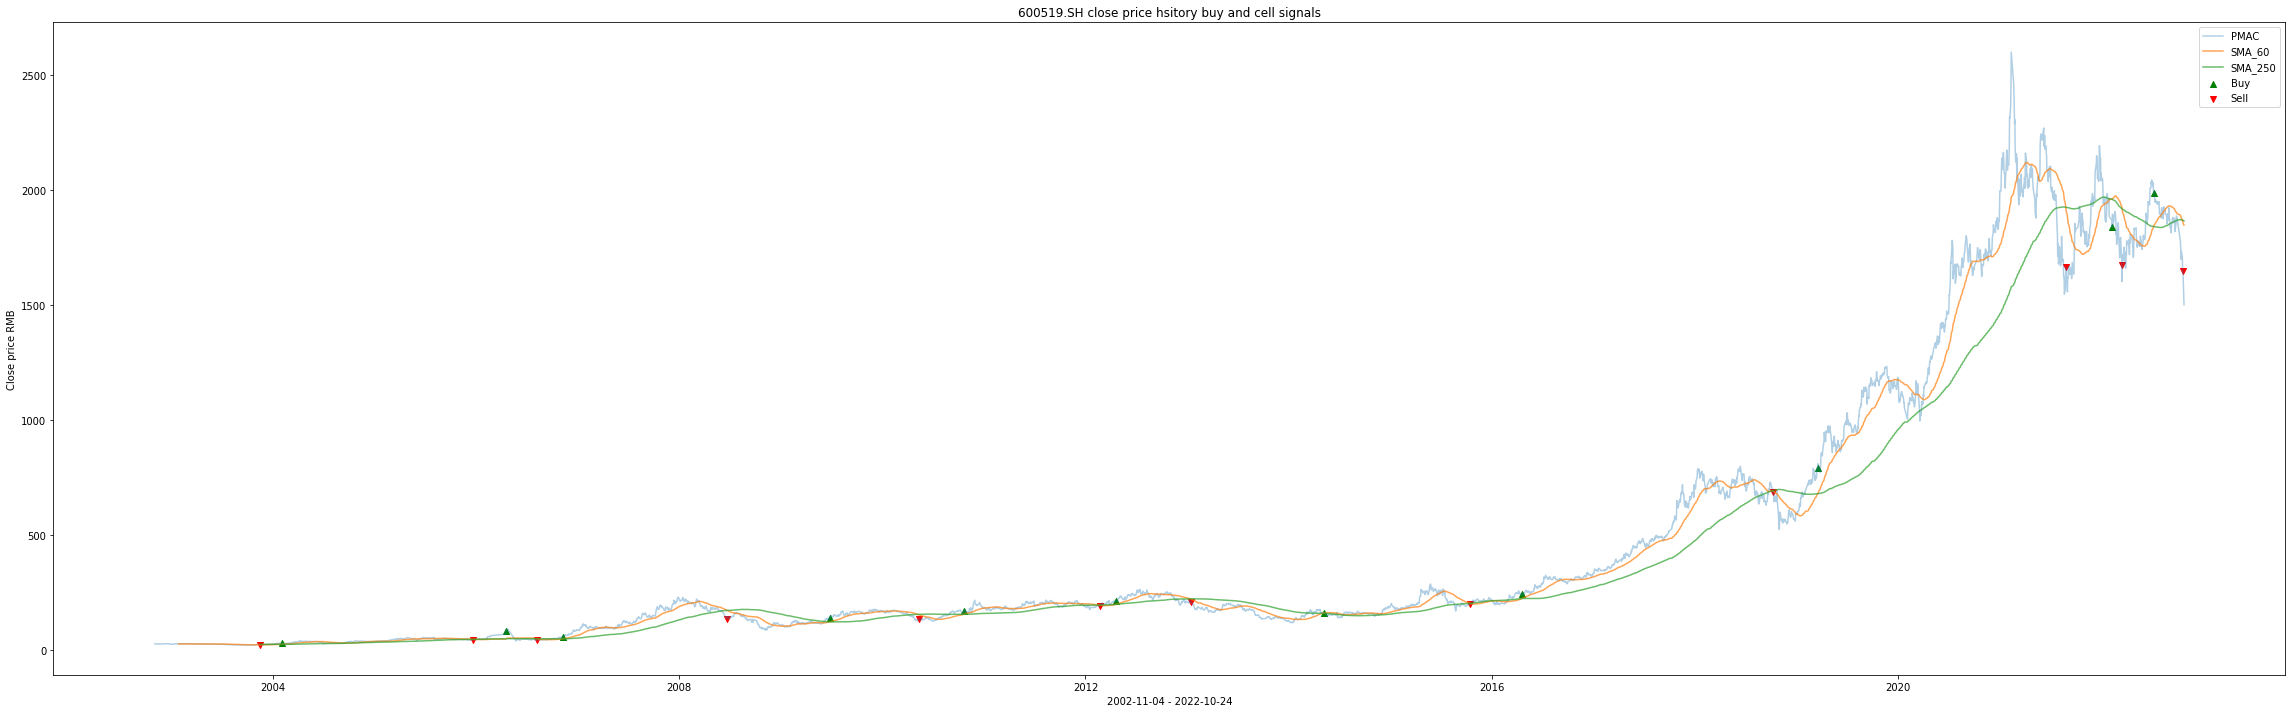

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-19               NaN            1648.00  2022-10-19
2022-07-07           1990.00                NaN  2022-07-07
2022-03-16               NaN            1674.95  2022-03-16
2022-02-08           1839.00                NaN  2022-02-08
2021-08-25               NaN            1665.02  2021-08-25
2019-03-19            792.61                NaN  2019-03-19
2018-10-08               NaN             686.15  2018-10-08
2016-04-18            243.68                NaN  2016-04-18
2015-10-16               NaN             200.74  2015-10-16
2014-05-07            160.66                NaN  2014-05-07
2013-01-14               NaN             209.42  2013-01-14
2012-04-20            212.50                NaN  2012-04-20
2012-02-21               NaN             191.95  2012-02-21
2010-10-20            167.41                NaN  2010-10-20
2010-05-11               NaN            

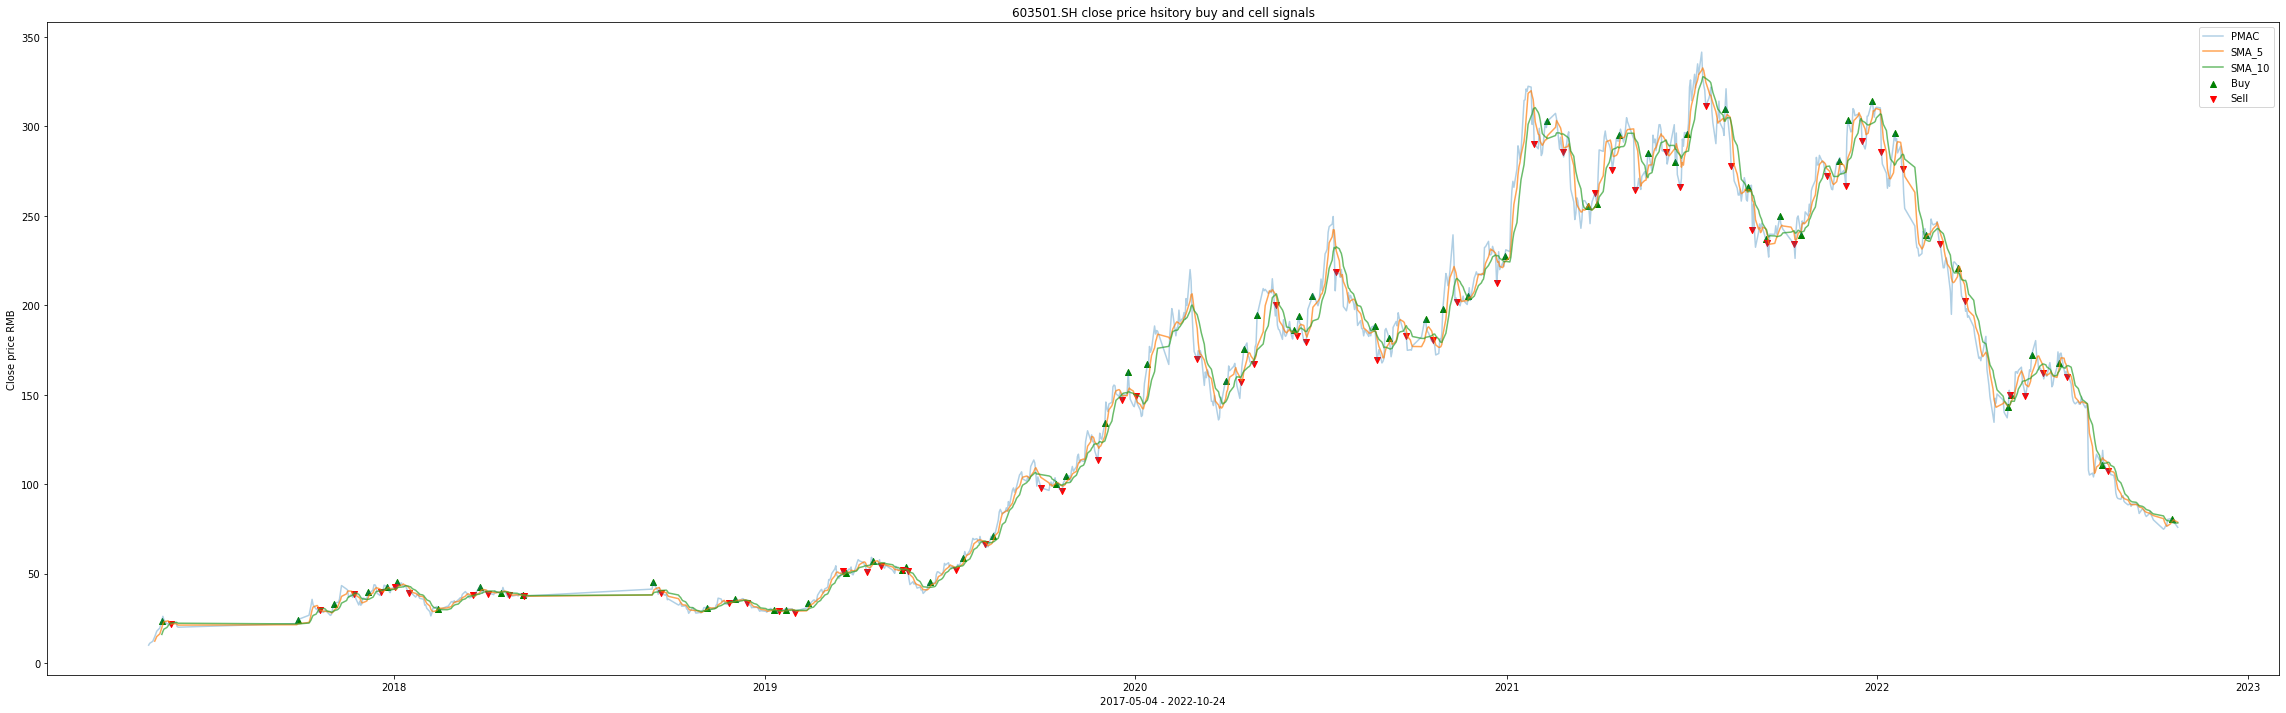

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-18             80.37                NaN  2022-10-18
2022-08-16               NaN             107.45  2022-08-16
2022-08-10            110.95                NaN  2022-08-10
2022-07-07               NaN             160.20  2022-07-07
2022-06-29            168.00                NaN  2022-06-29
...                      ...                ...         ...
2017-11-03             33.37                NaN  2017-11-03
2017-10-20               NaN              29.53  2017-10-20
2017-09-28             24.39                NaN  2017-09-28
2017-05-26               NaN              21.92  2017-05-26
2017-05-17             23.84                NaN  2017-05-17

[127 rows x 3 columns]
韦尔股份 603501.SH
short_term_days: 5 long_term_days: 10
earnings: -159.08000000000007%
data length: 1160


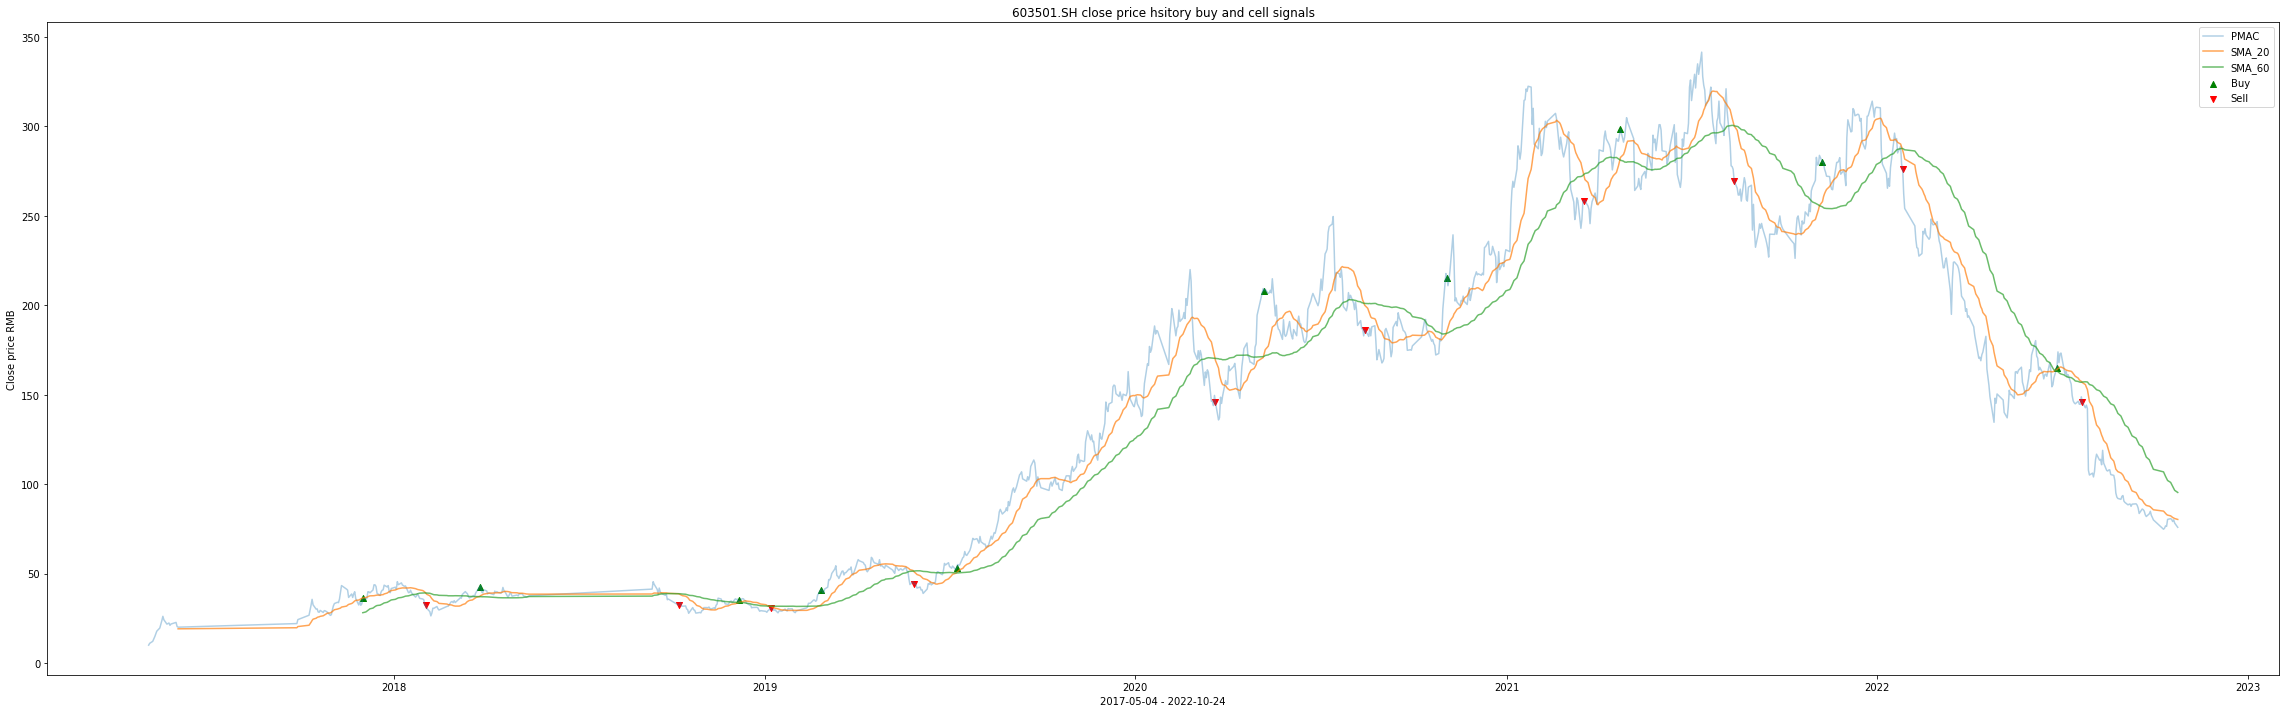

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-07-22               NaN             145.88  2022-07-22
2022-06-27            165.20                NaN  2022-06-27
2022-01-26               NaN             276.38  2022-01-26
2021-11-08            279.99                NaN  2021-11-08
2021-08-13               NaN             269.59  2021-08-13
2021-04-23            298.50                NaN  2021-04-23
2021-03-18               NaN             258.61  2021-03-18
2020-11-03            215.59                NaN  2020-11-03
2020-08-14               NaN             186.28  2020-08-14
2020-05-07            208.19                NaN  2020-05-07
2020-03-20               NaN             145.74  2020-03-20
2019-07-09             53.30                NaN  2019-07-09
2019-05-28               NaN              44.20  2019-05-28
2019-02-25             40.80                NaN  2019-02-25
2019-01-07               NaN            

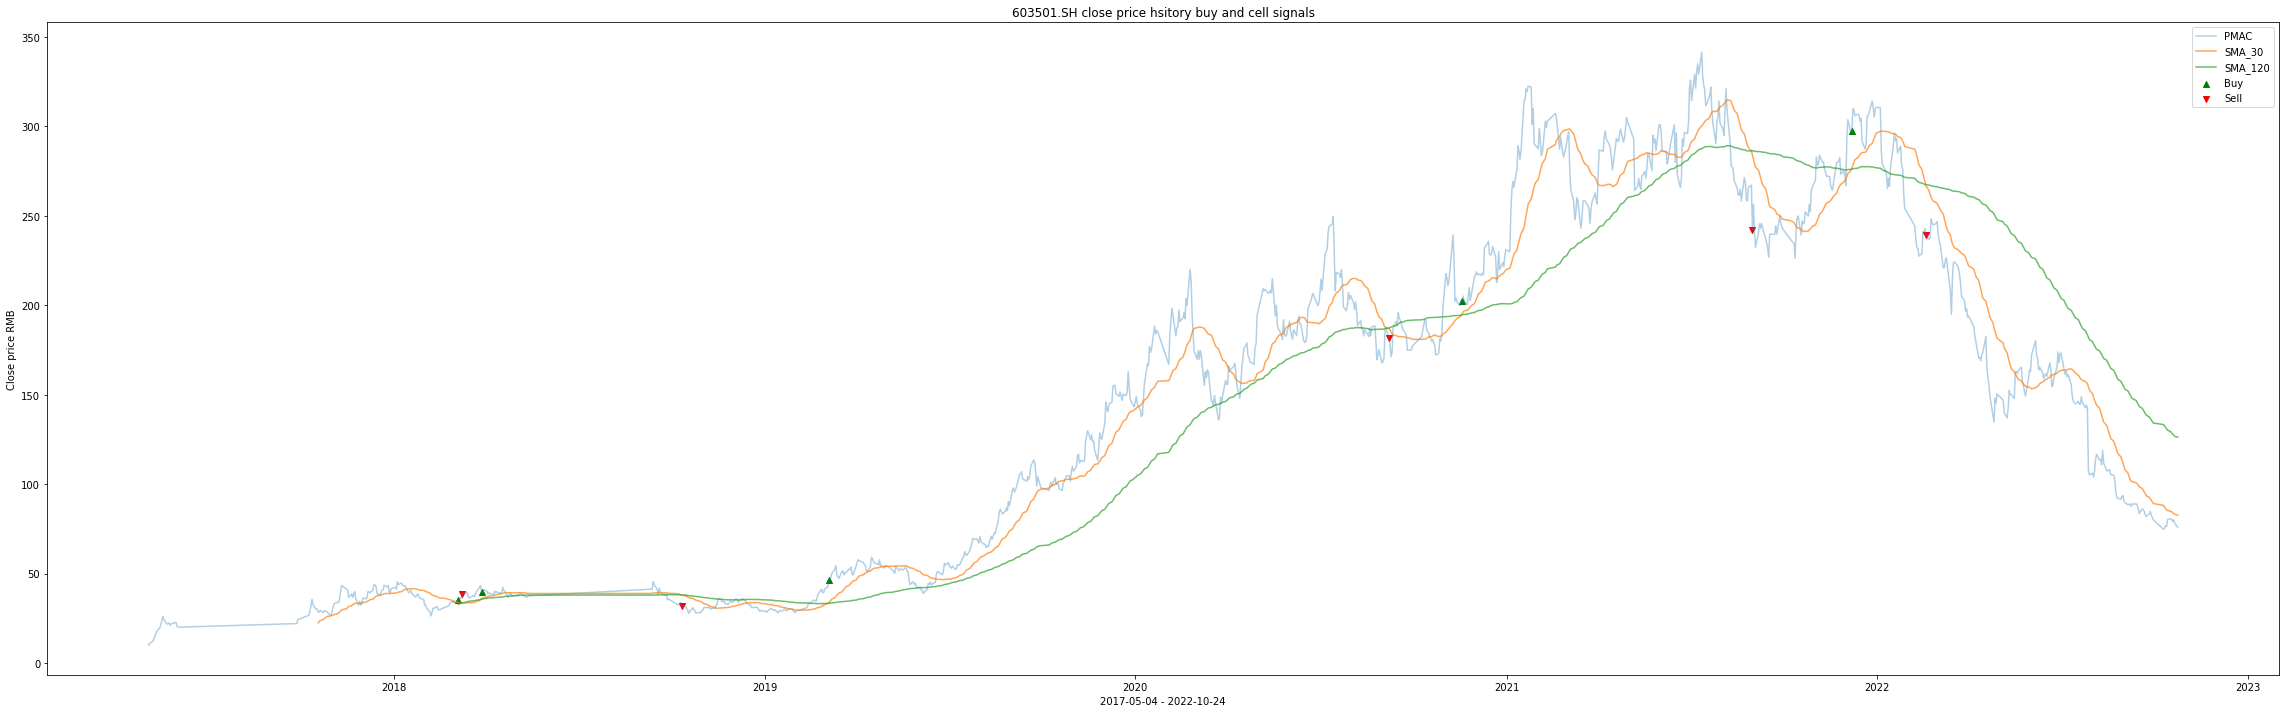

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-02-18               NaN             239.40  2022-02-18
2021-12-07            297.31                NaN  2021-12-07
2021-08-31               NaN             242.09  2021-08-31
2020-11-18            202.54                NaN  2020-11-18
2020-09-07               NaN             182.00  2020-09-07
2019-03-05             46.75                NaN  2019-03-05
2018-10-11               NaN              31.91  2018-10-11
2018-03-28             39.94                NaN  2018-03-28
2018-03-09               NaN              38.46  2018-03-09
2018-03-05             35.47                NaN  2018-03-05
韦尔股份 603501.SH
short_term_days: 30 long_term_days: 120
earnings: 111.85%
data length: 1160


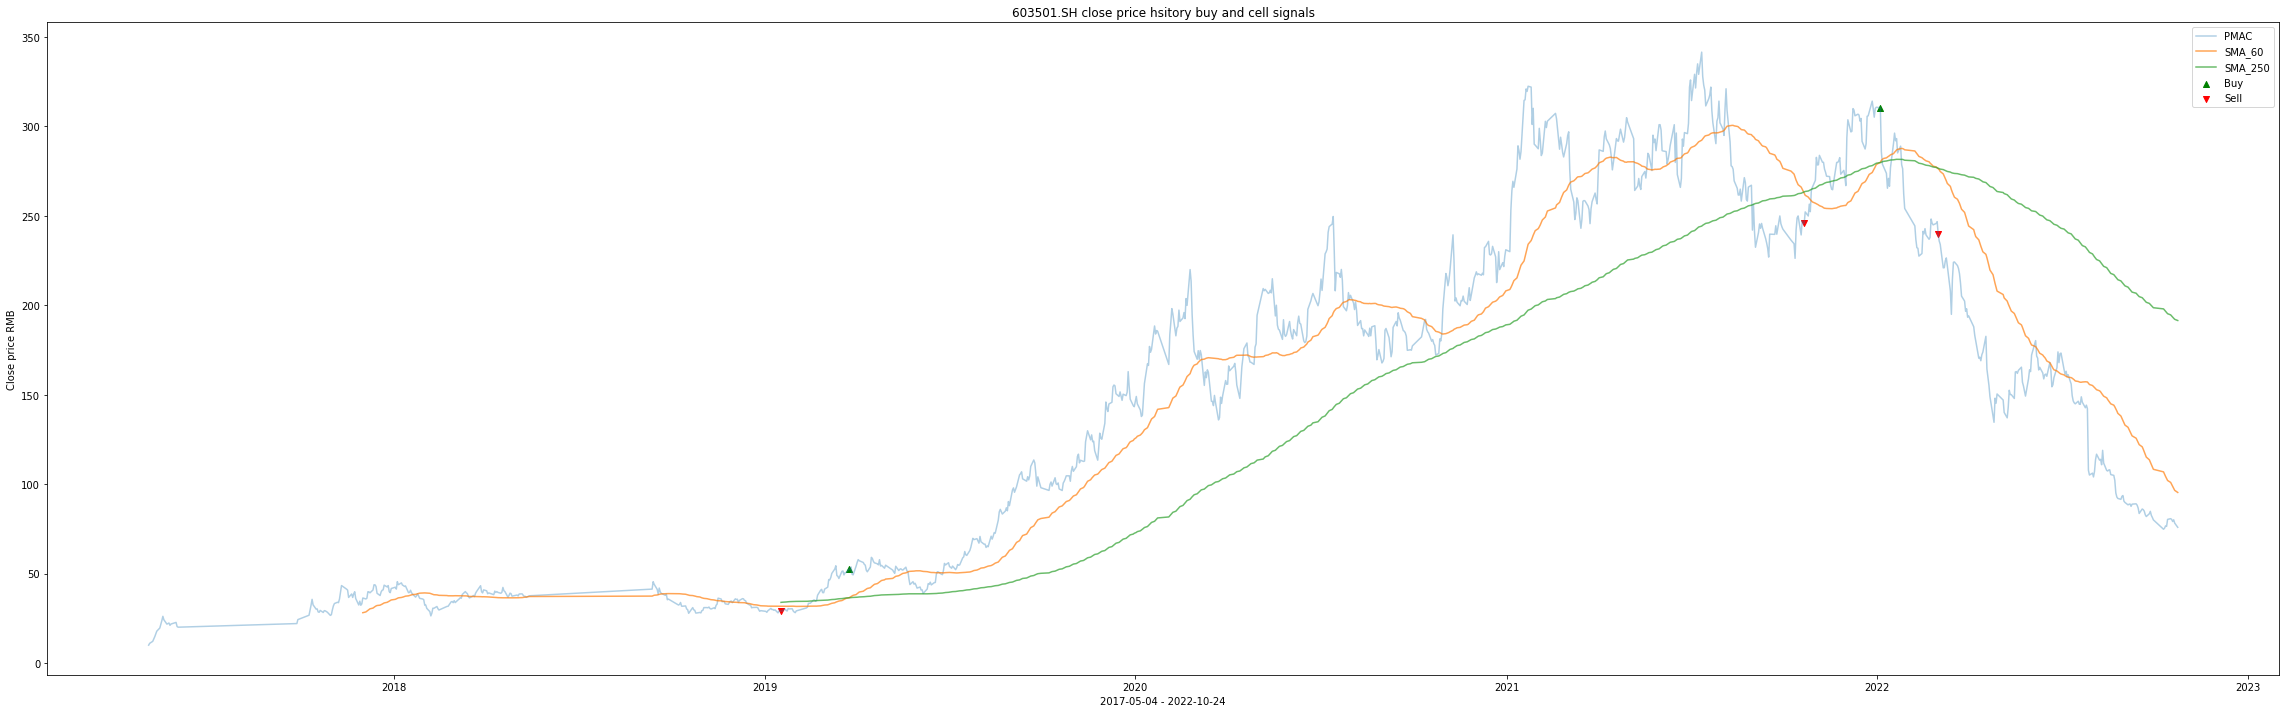

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-03-02               NaN             240.00  2022-03-02
2022-01-04            310.42                NaN  2022-01-04
2021-10-21               NaN             246.00  2021-10-21
2019-03-25             52.67                NaN  2019-03-25
2019-01-17               NaN              29.12  2019-01-17
韦尔股份 603501.SH
short_term_days: 60 long_term_days: 250
earnings: 152.03%
data length: 1160


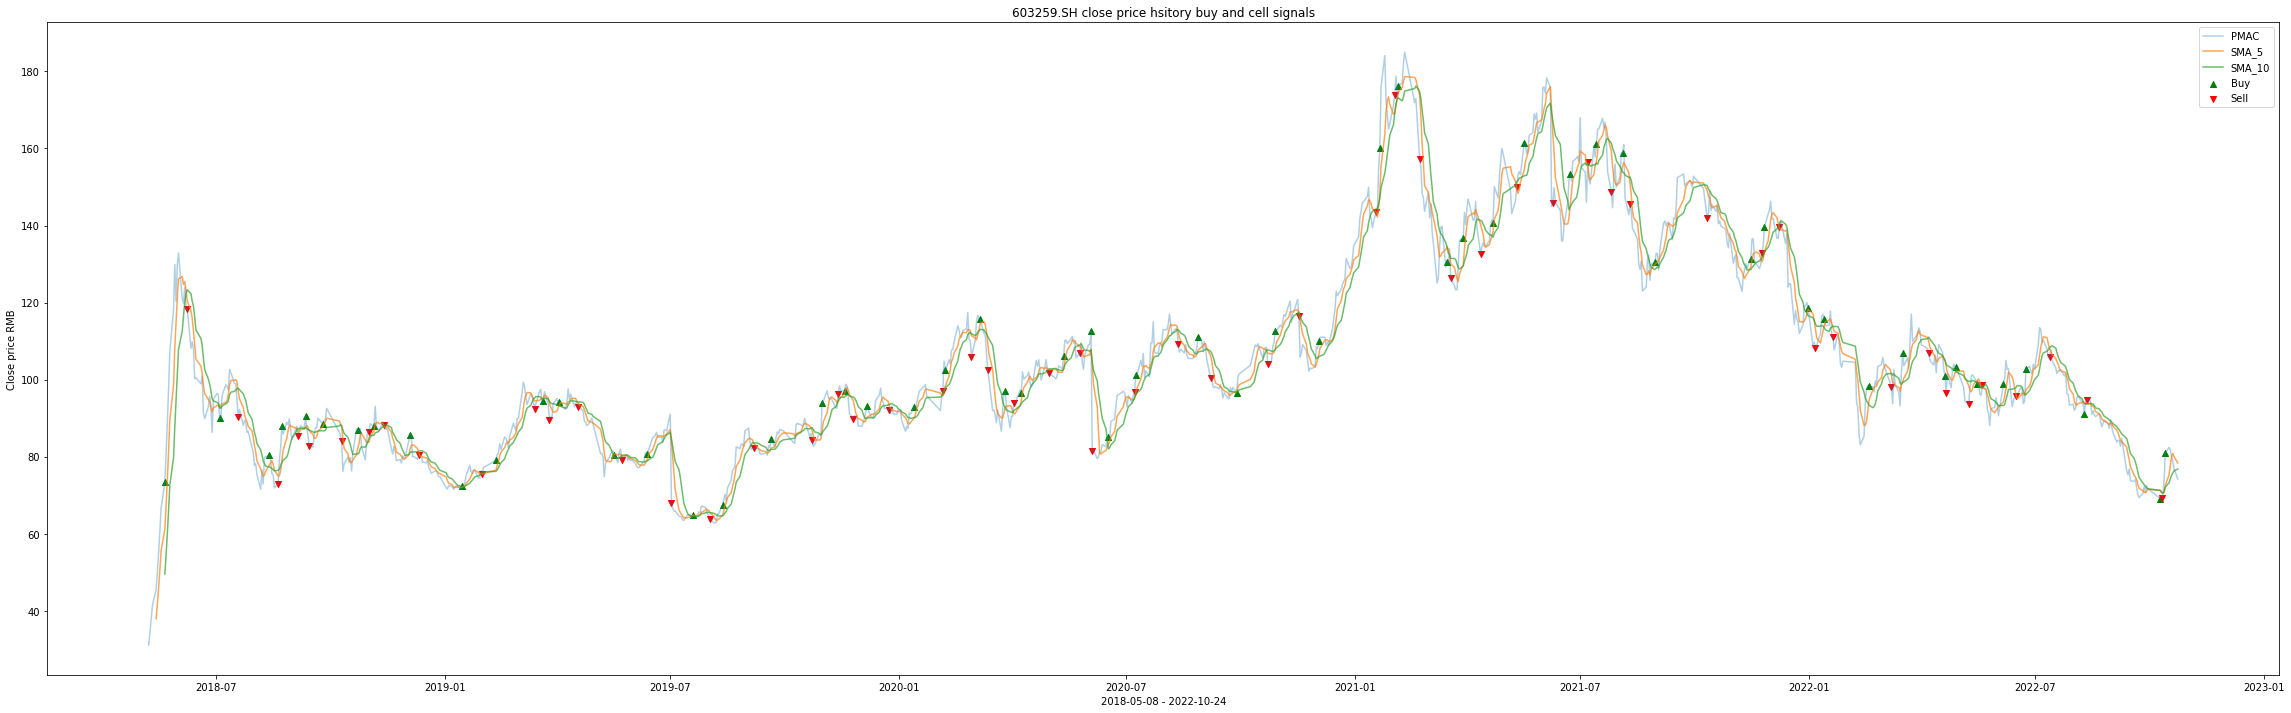

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-14             80.96                NaN  2022-10-14
2022-10-11               NaN              69.40  2022-10-11
2022-10-10             69.15                NaN  2022-10-10
2022-08-12               NaN              94.74  2022-08-12
2022-08-10             91.15                NaN  2022-08-10
...                      ...                ...         ...
2018-08-13             80.36                NaN  2018-08-13
2018-07-19               NaN              90.21  2018-07-19
2018-07-04             89.96                NaN  2018-07-04
2018-06-08               NaN             118.46  2018-06-08
2018-05-21             73.33                NaN  2018-05-21

[115 rows x 3 columns]
药明康德 603259.SH
short_term_days: 5 long_term_days: 10
earnings: -93.49999999999996%
data length: 1085


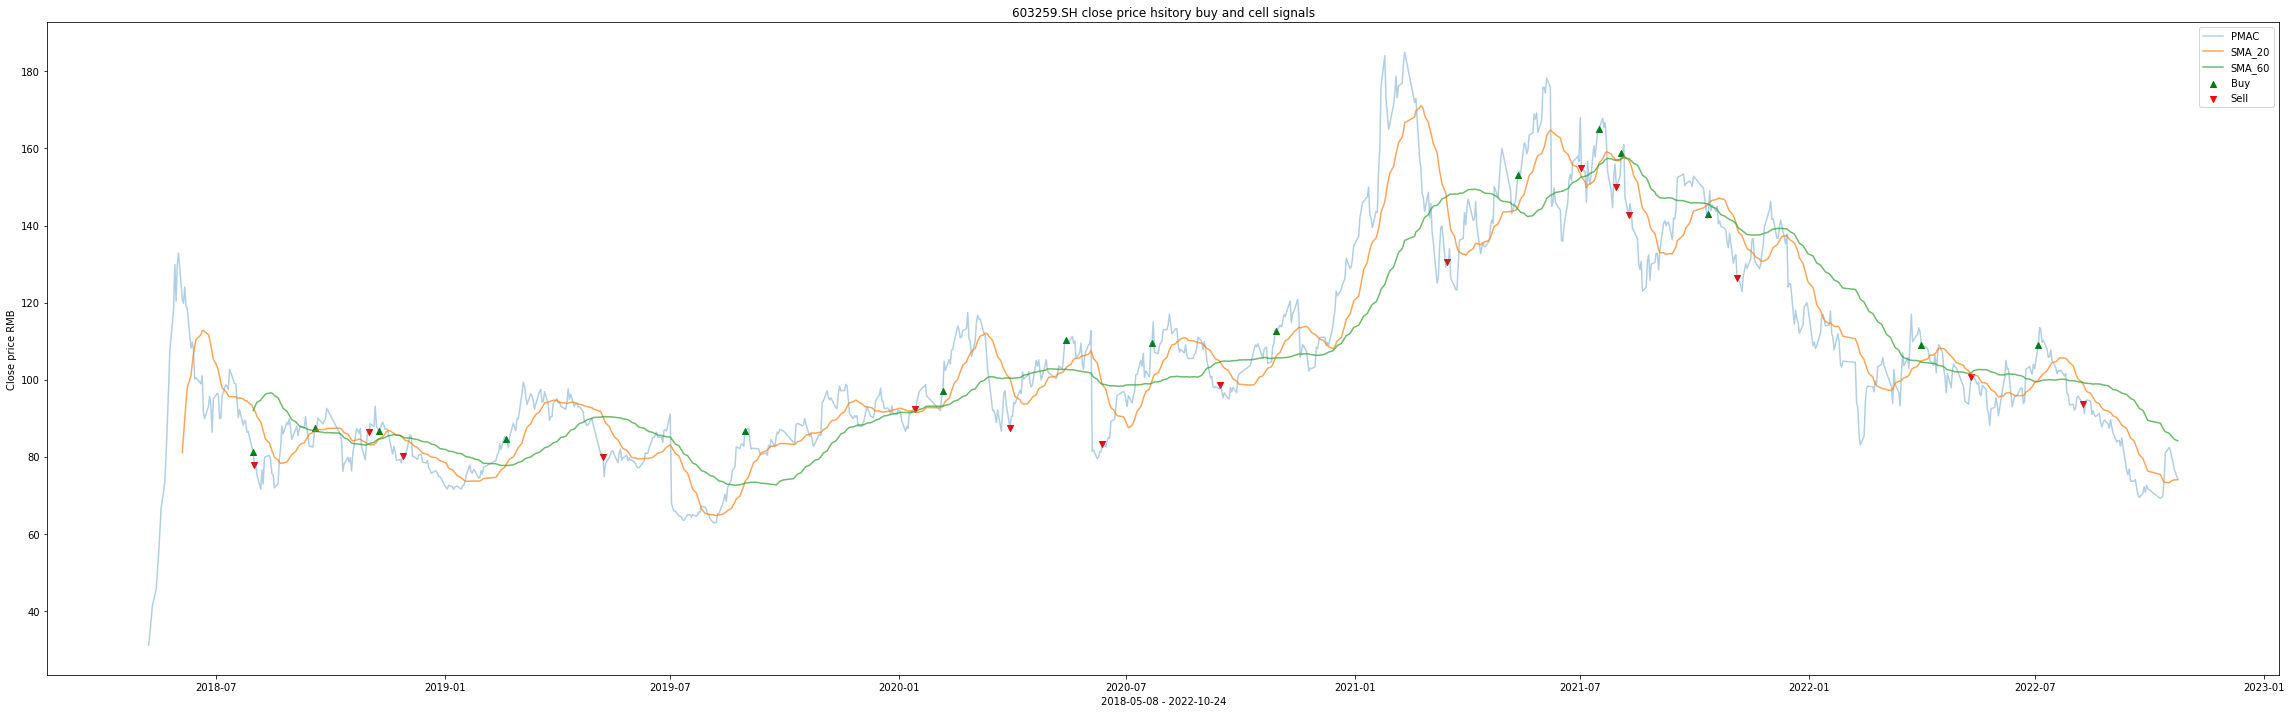

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-08-09               NaN              93.75  2022-08-09
2022-07-04            109.11                NaN  2022-07-04
2022-05-11               NaN             100.65  2022-05-11
2022-04-01            109.07                NaN  2022-04-01
2021-11-04               NaN             126.49  2021-11-04
2021-10-12            143.03                NaN  2021-10-12
2021-08-09               NaN             142.78  2021-08-09
2021-08-03            158.88                NaN  2021-08-03
2021-07-30               NaN             150.00  2021-07-30
2021-07-16            165.10                NaN  2021-07-16
2021-07-02               NaN             155.05  2021-07-02
2021-05-12            153.18                NaN  2021-05-12
2021-03-16               NaN             130.50  2021-03-16
2020-10-30            112.72                NaN  2020-10-30
2020-09-15               NaN            

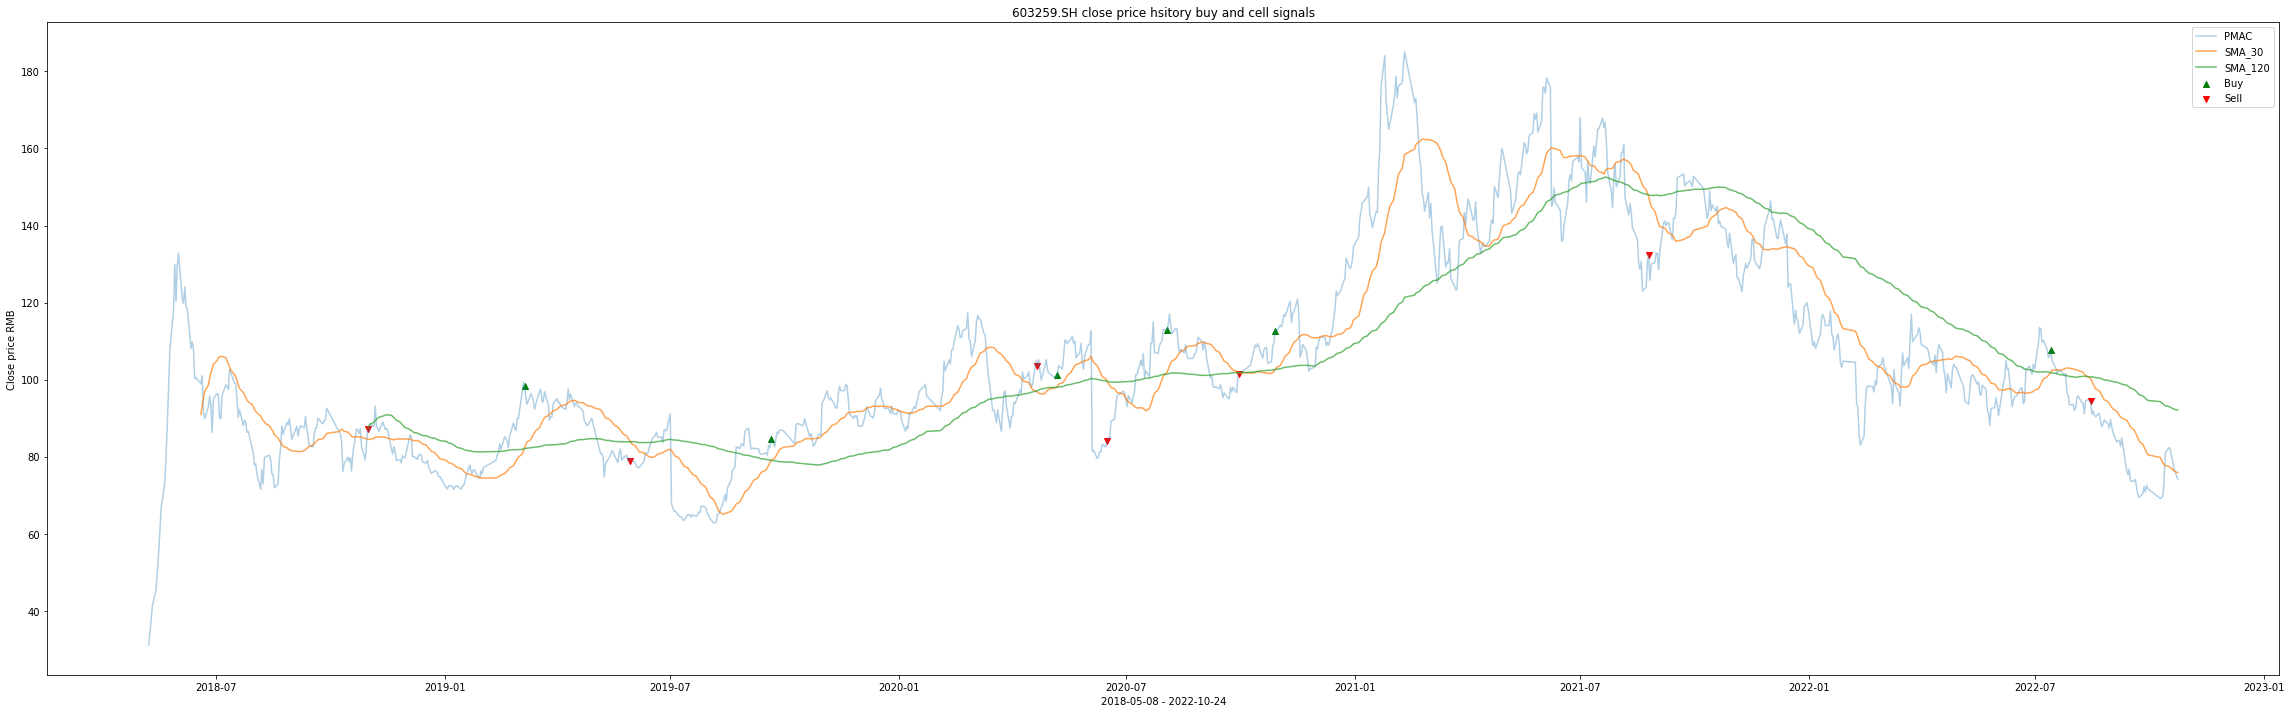

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-08-15               NaN              94.47  2022-08-15
2022-07-14            107.75                NaN  2022-07-14
2021-08-25               NaN             132.38  2021-08-25
2020-10-29            112.75                NaN  2020-10-29
2020-09-30               NaN             101.50  2020-09-30
2020-08-03            112.93                NaN  2020-08-03
2020-06-16               NaN              84.20  2020-06-16
2020-05-07            101.29                NaN  2020-05-07
2020-04-21               NaN             103.49  2020-04-21
2019-09-20             84.50                NaN  2019-09-20
2019-05-30               NaN              79.00  2019-05-30
2019-03-06             98.28                NaN  2019-03-06
2018-10-31               NaN              87.15  2018-10-31
药明康德 603259.SH
short_term_days: 30 long_term_days: 120
earnings: 64.69%
data length: 1085


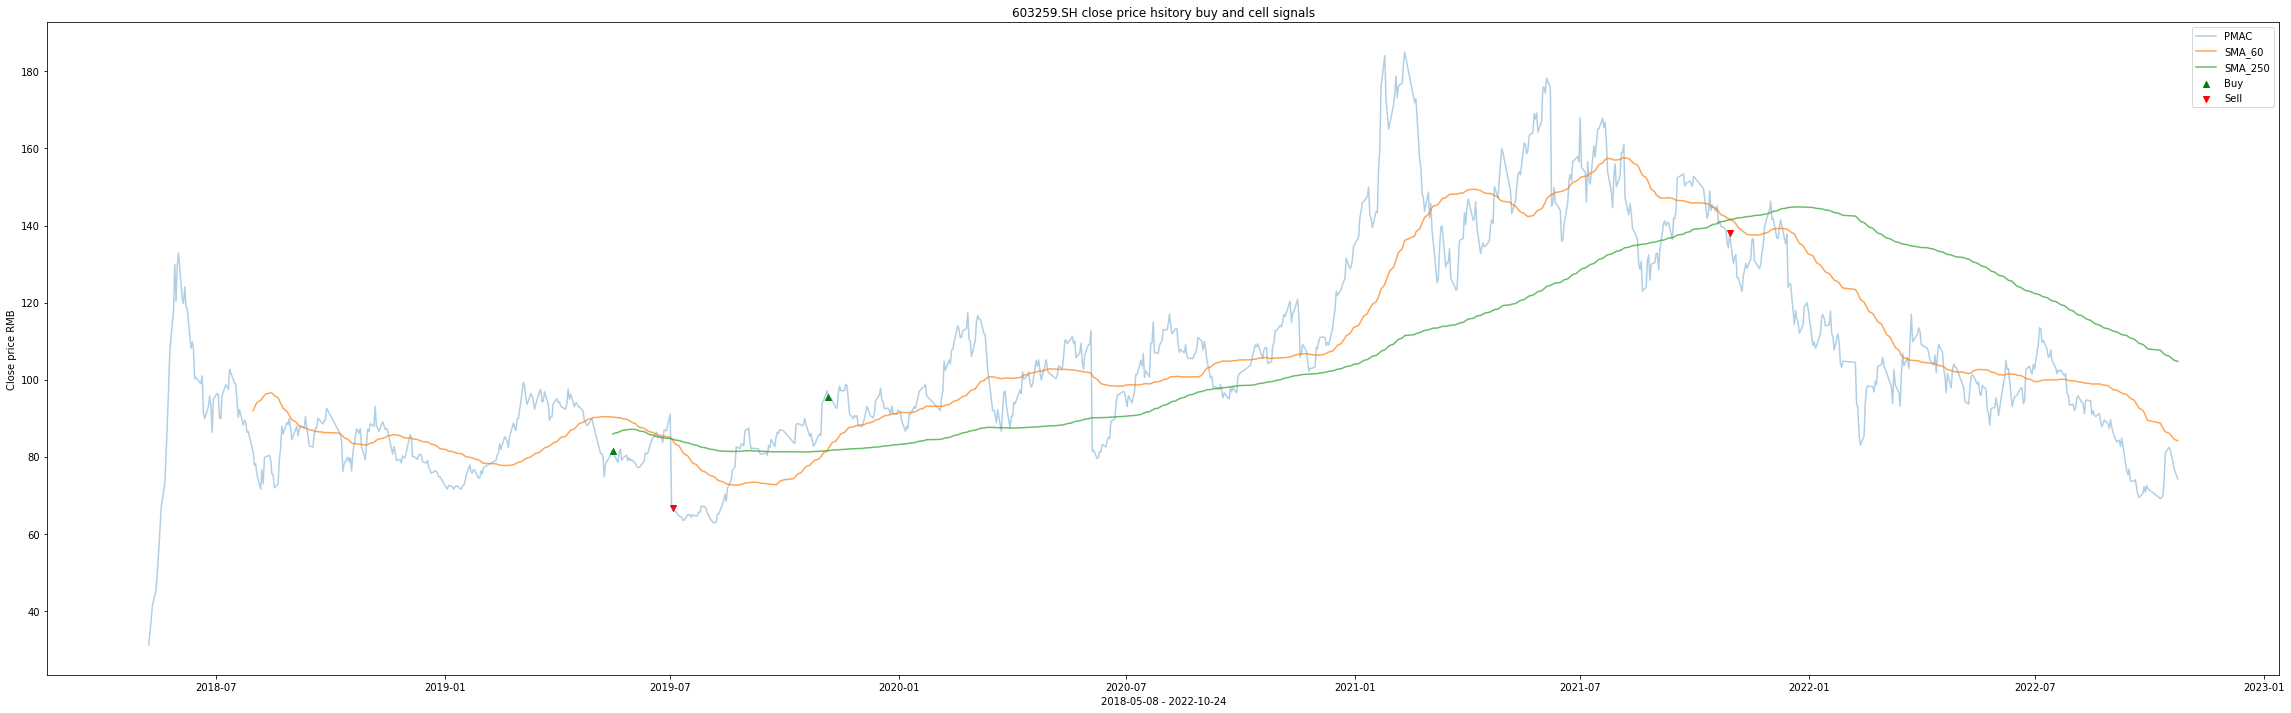

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2021-10-29               NaN             138.01  2021-10-29
2019-11-05             95.47                NaN  2019-11-05
2019-07-03               NaN              66.75  2019-07-03
2019-05-16             81.47                NaN  2019-05-16
药明康德 603259.SH
short_term_days: 60 long_term_days: 250
earnings: 27.82%
data length: 1085


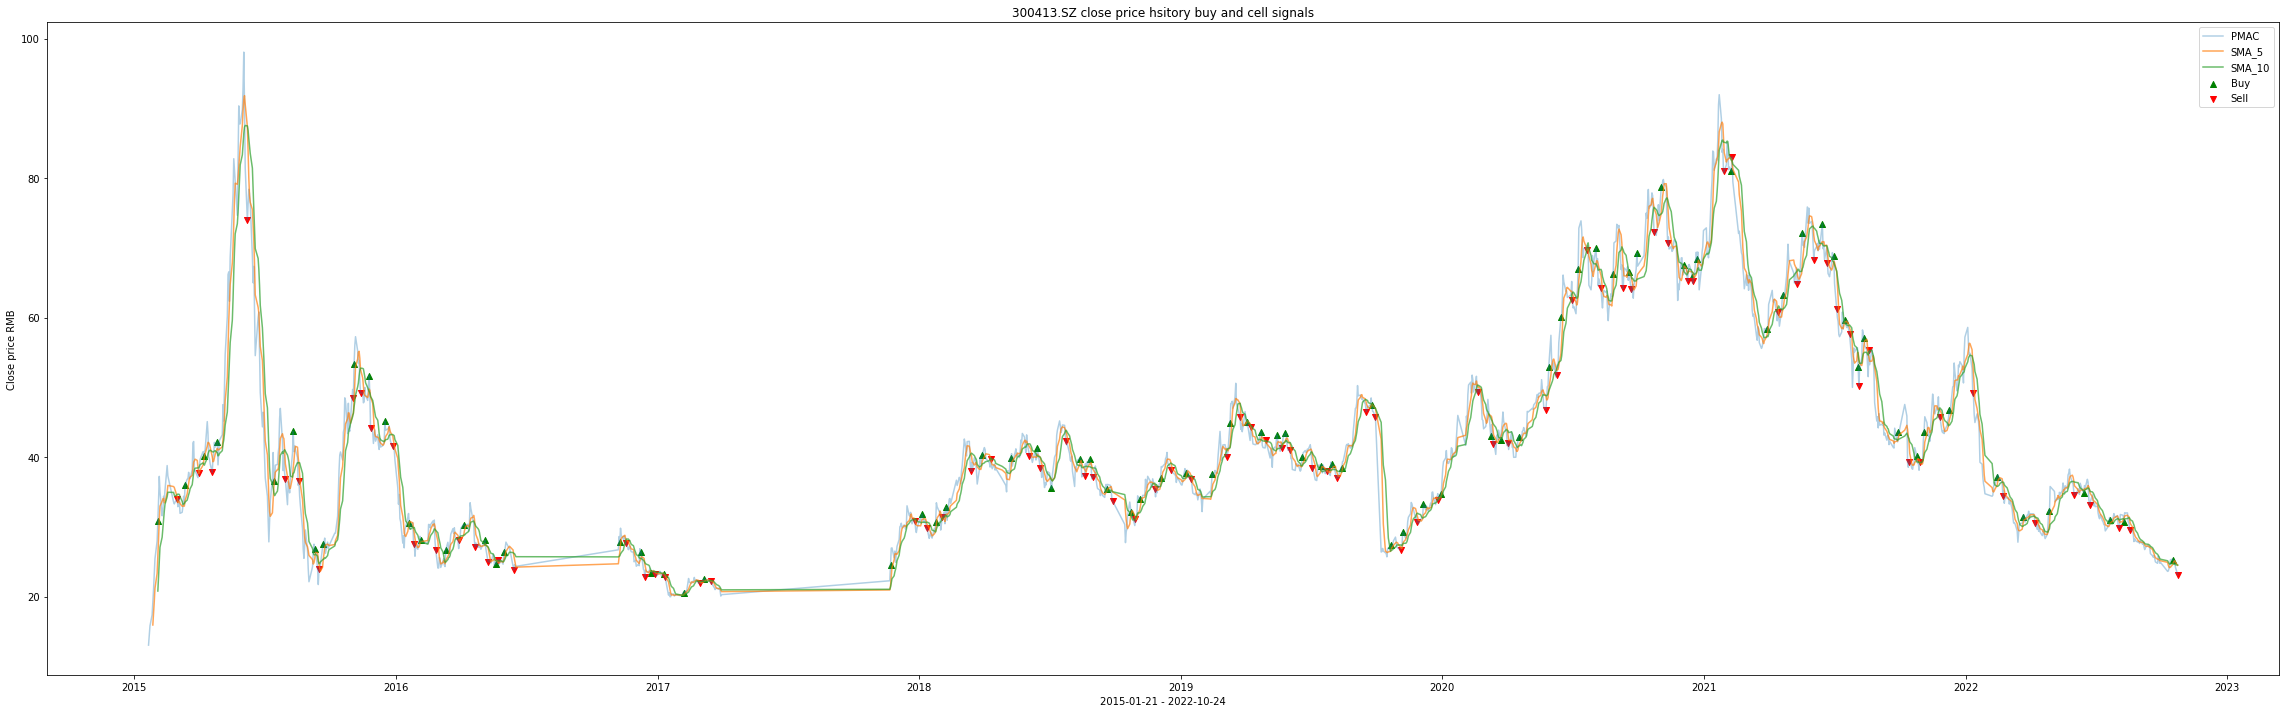

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-24               NaN              23.18  2022-10-24
2022-10-18             25.21                NaN  2022-10-18
2022-08-18               NaN              29.51  2022-08-18
2022-08-10             30.70                NaN  2022-08-10
2022-08-03               NaN              29.91  2022-08-03
...                      ...                ...         ...
2015-04-08             40.20                NaN  2015-04-08
2015-04-01               NaN              37.80  2015-04-01
2015-03-13             35.97                NaN  2015-03-13
2015-03-02               NaN              34.06  2015-03-02
2015-02-03             30.78                NaN  2015-02-03

[176 rows x 3 columns]
芒果超媒 300413.SZ
short_term_days: 5 long_term_days: 10
earnings: 14.230000000000045%
data length: 1626


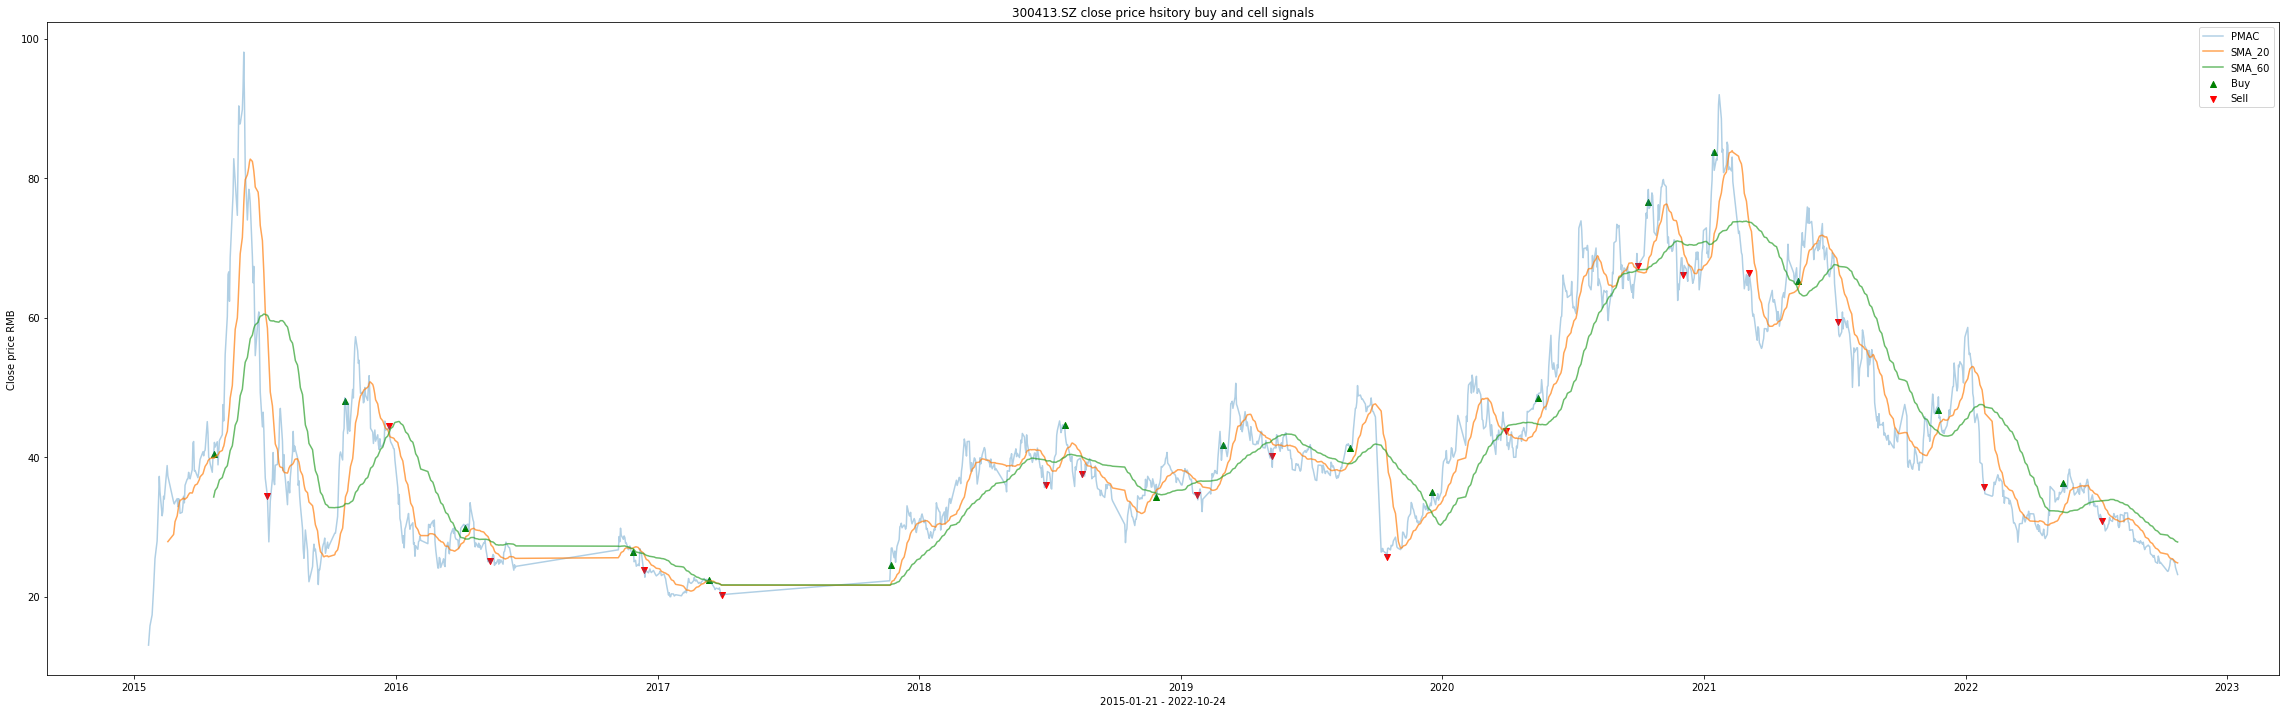

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-07-11               NaN              30.88  2022-07-11
2022-05-17             36.30                NaN  2022-05-17
2022-01-27               NaN              35.66  2022-01-27
2021-11-23             46.71                NaN  2021-11-23
2021-07-07               NaN              59.41  2021-07-07
2021-05-12             65.31                NaN  2021-05-12
2021-03-05               NaN              66.43  2021-03-05
2021-01-14             83.78                NaN  2021-01-14
2020-12-02               NaN              66.11  2020-12-02
2020-10-14             76.53                NaN  2020-10-14
2020-09-30               NaN              67.40  2020-09-30
2020-05-14             48.55                NaN  2020-05-14
2020-03-30               NaN              43.80  2020-03-30
2019-12-18             34.96                NaN  2019-12-18
2019-10-16               NaN            

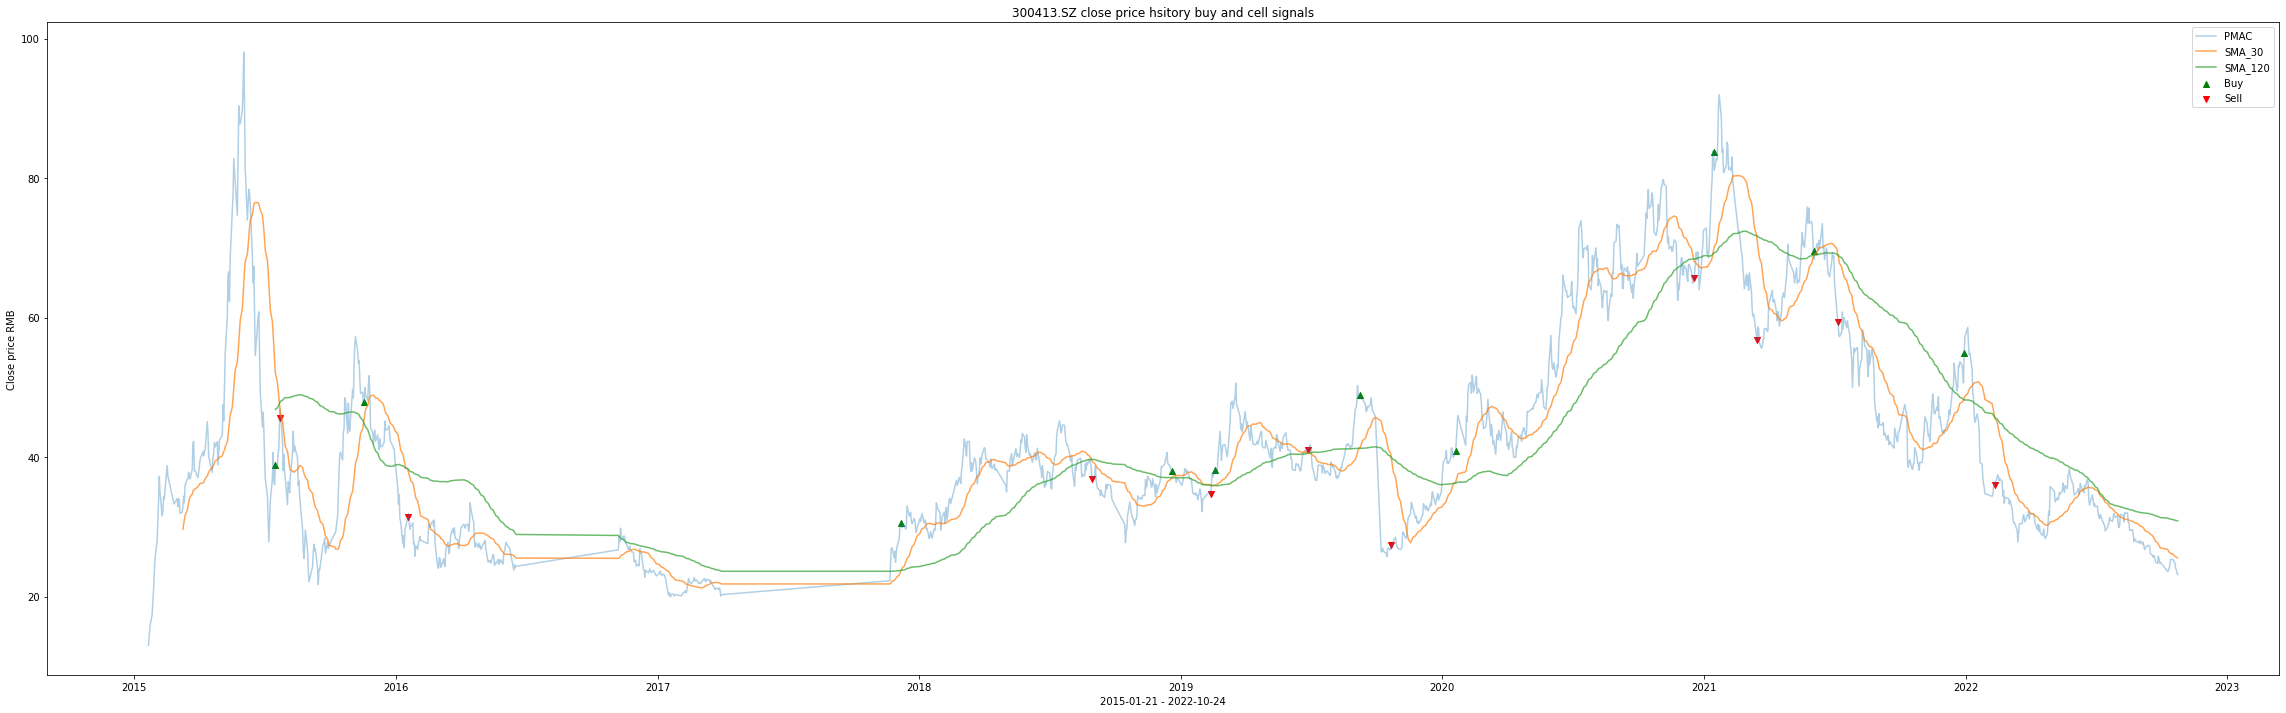

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-02-11               NaN              36.08  2022-02-11
2021-12-30             55.00                NaN  2021-12-30
2021-07-07               NaN              59.41  2021-07-07
2021-06-04             69.62                NaN  2021-06-04
2021-03-16               NaN              56.77  2021-03-16
2021-01-14             83.78                NaN  2021-01-14
2020-12-18               NaN              65.70  2020-12-18
2020-01-20             40.93                NaN  2020-01-20
2019-10-22               NaN              27.37  2019-10-22
2019-09-09             48.91                NaN  2019-09-09
2019-06-28               NaN              41.05  2019-06-28
2019-02-18             38.10                NaN  2019-02-18
2019-02-12               NaN              34.72  2019-02-12
2018-12-20             38.00                NaN  2018-12-20
2018-08-30               NaN            

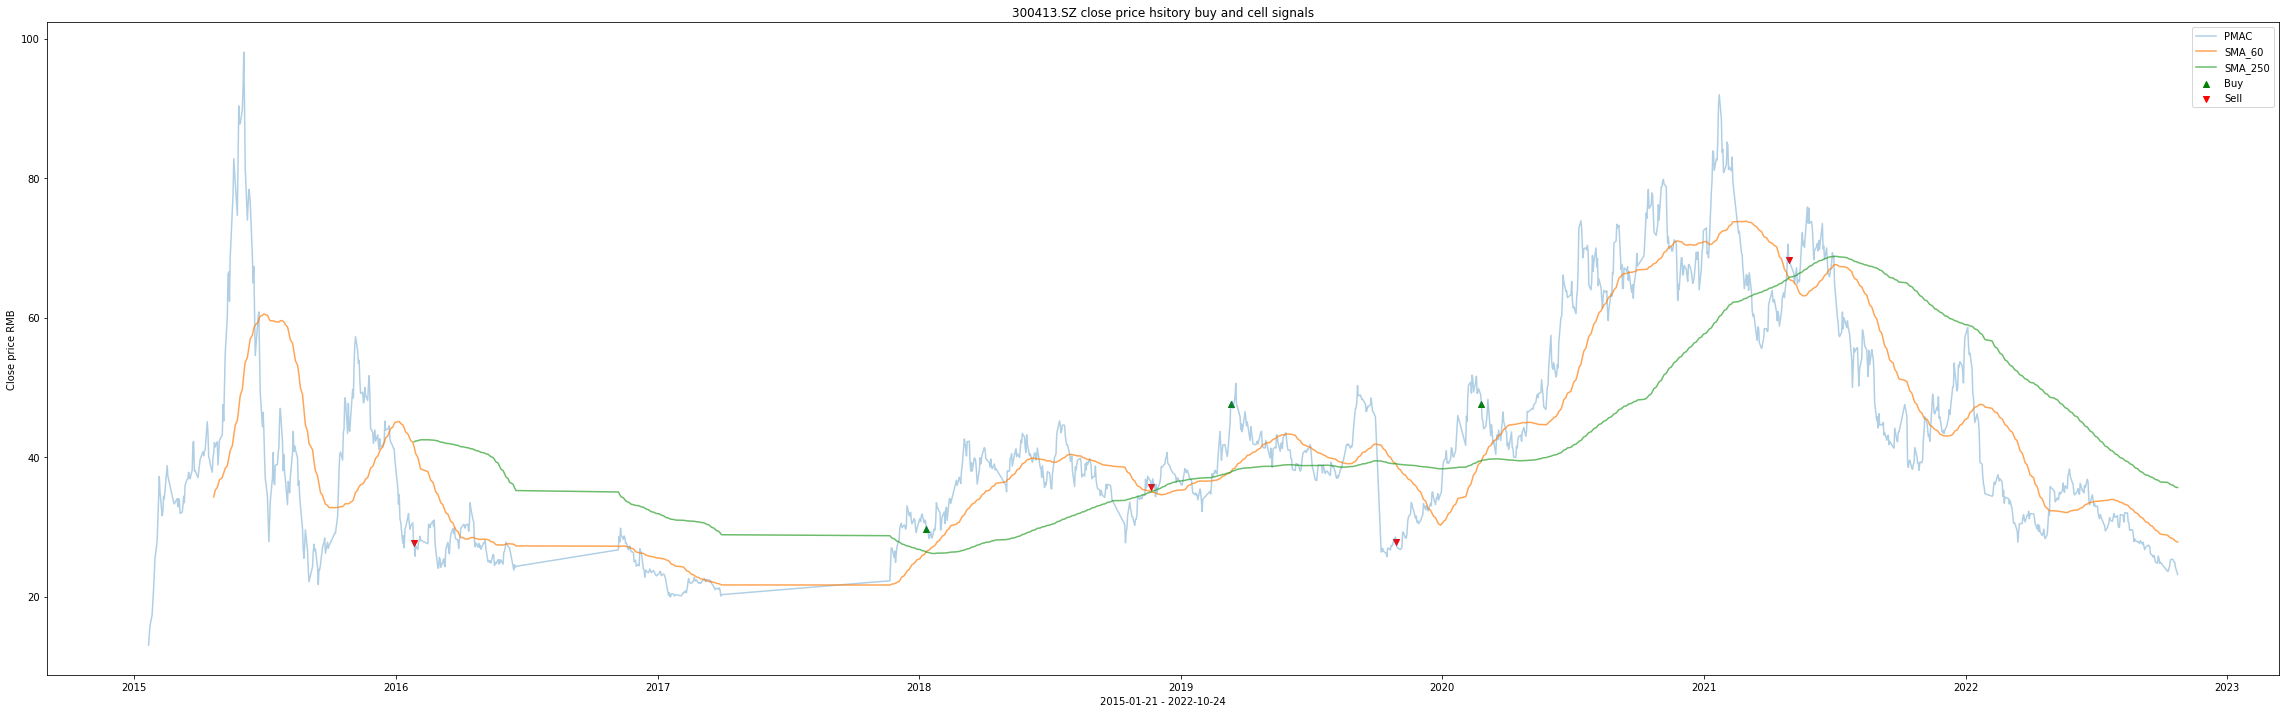

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2021-04-29               NaN              68.33  2021-04-29
2020-02-25             47.59                NaN  2020-02-25
2019-10-29               NaN              27.86  2019-10-29
2019-03-12             47.69                NaN  2019-03-12
2018-11-21               NaN              35.70  2018-11-21
2018-01-11             29.65                NaN  2018-01-11
2016-01-27               NaN              27.75  2016-01-27
芒果超媒 300413.SZ
short_term_days: 60 long_term_days: 250
earnings: 34.71000000000001%
data length: 1626


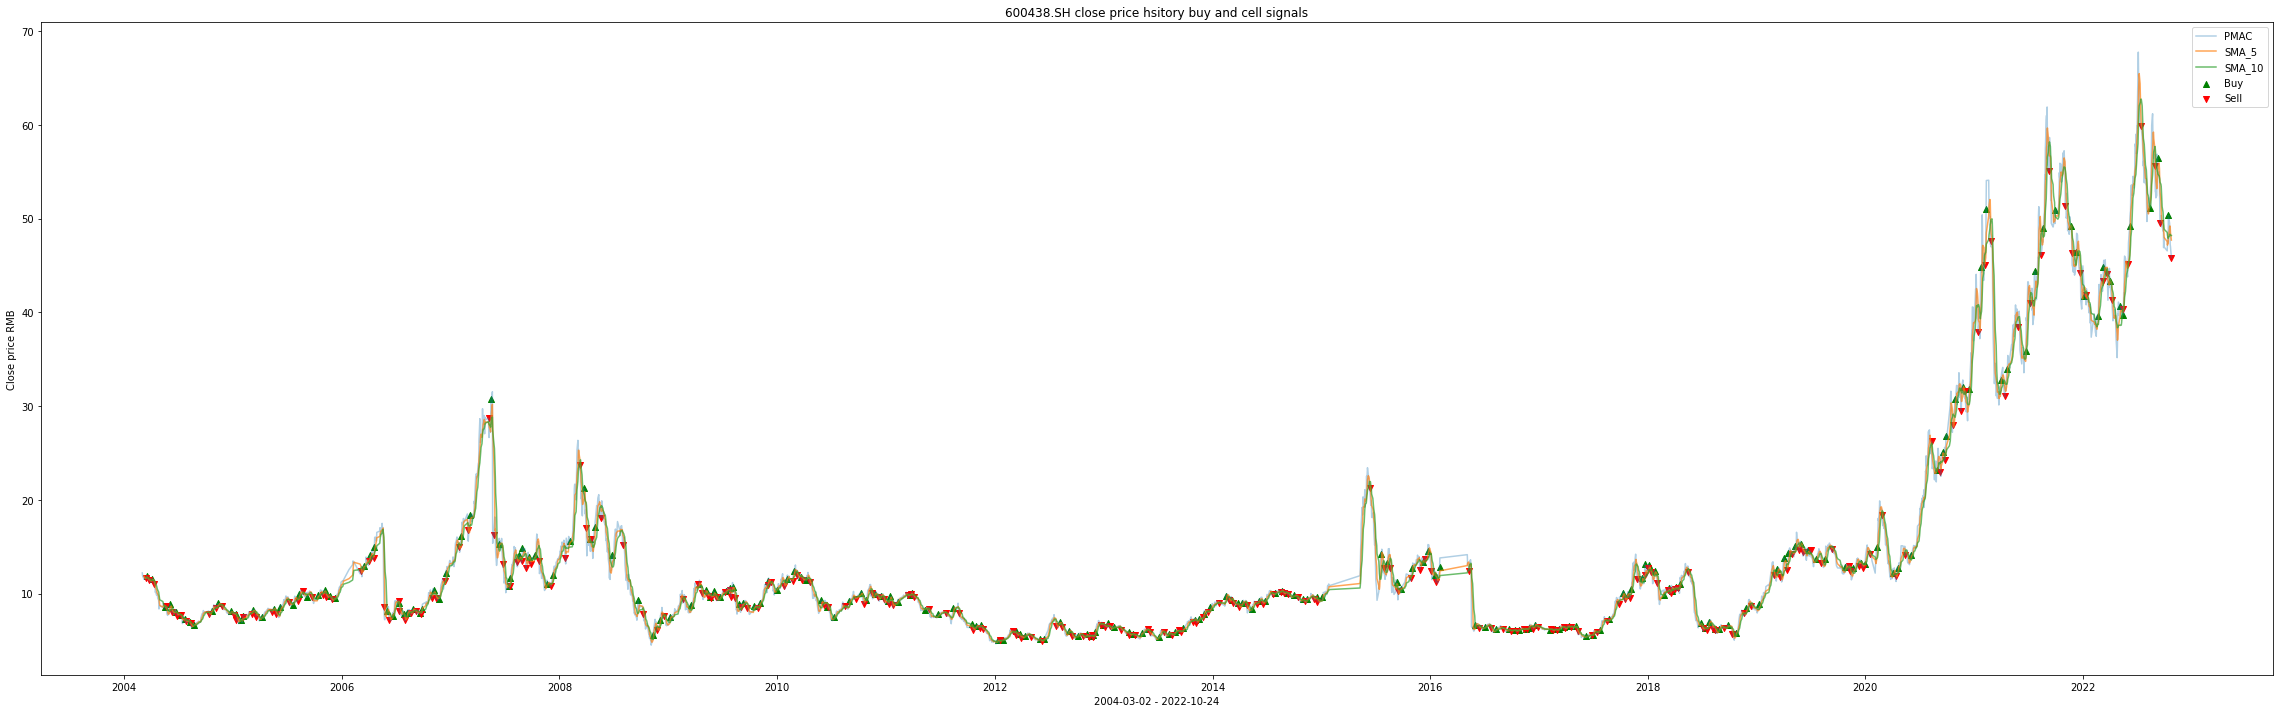

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-24               NaN              45.82  2022-10-24
2022-10-14             50.35                NaN  2022-10-14
2022-09-16               NaN              49.52  2022-09-16
2022-09-08             56.50                NaN  2022-09-08
2022-08-30               NaN              55.56  2022-08-30
...                      ...                ...         ...
2004-04-12               NaN              11.00  2004-04-12
2004-04-05             11.52                NaN  2004-04-05
2004-03-23               NaN              11.46  2004-03-23
2004-03-17             11.90                NaN  2004-03-17
2004-03-15               NaN              11.68  2004-03-15

[475 rows x 3 columns]
通威股份 600438.SH
short_term_days: 5 long_term_days: 10
earnings: 52.72%
data length: 4331


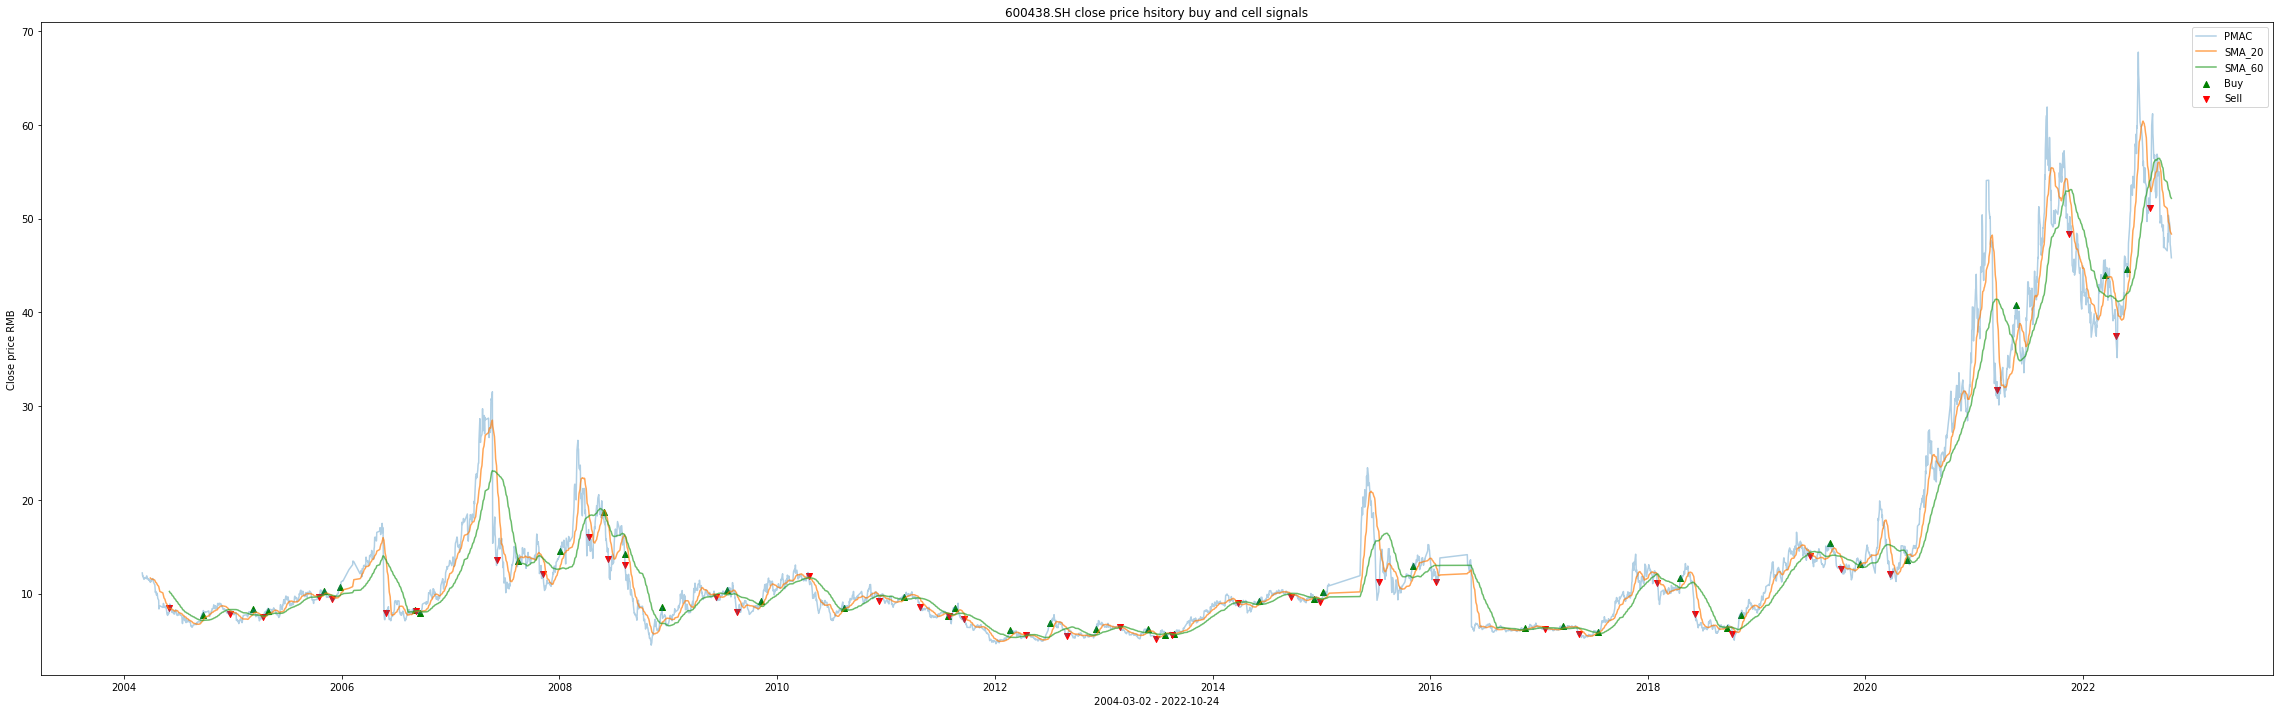

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-08-12               NaN              51.12  2022-08-12
2022-05-27             44.67                NaN  2022-05-27
2022-04-21               NaN              37.44  2022-04-21
2022-03-14             44.02                NaN  2022-03-14
2021-11-15               NaN              48.33  2021-11-15
...                      ...                ...         ...
2005-04-11               NaN               7.49  2005-04-11
2005-03-08              8.32                NaN  2005-03-08
2004-12-20               NaN               7.80  2004-12-20
2004-09-22              7.76                NaN  2004-09-22
2004-06-01               NaN               8.42  2004-06-01

[81 rows x 3 columns]
通威股份 600438.SH
short_term_days: 20 long_term_days: 60
earnings: 33.07%
data length: 4331


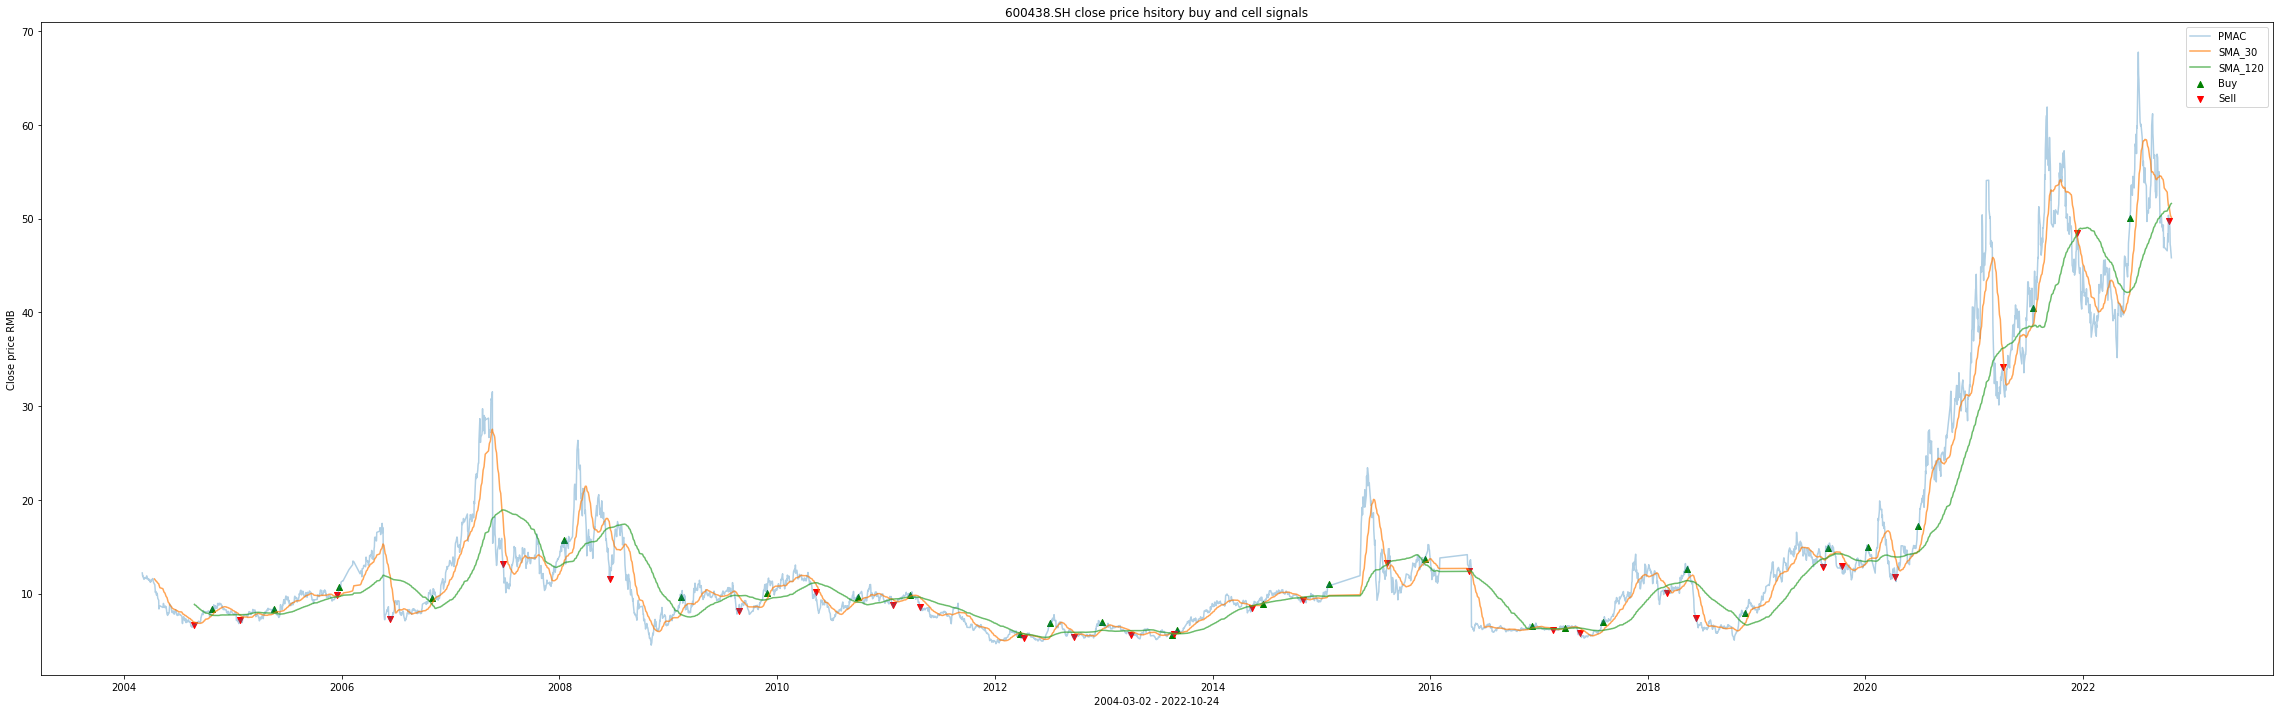

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-10-17               NaN              49.76  2022-10-17
2022-06-07             50.05                NaN  2022-06-07
2021-12-10               NaN              48.43  2021-12-10
2021-07-15             40.43                NaN  2021-07-15
2021-04-06               NaN              34.13  2021-04-06
2020-06-24             17.20                NaN  2020-06-24
2020-04-10               NaN              11.78  2020-04-10
2020-01-09             14.93                NaN  2020-01-09
2019-10-14               NaN              12.92  2019-10-14
2019-08-27             14.90                NaN  2019-08-27
2019-08-13               NaN              12.80  2019-08-13
2018-11-22              7.89                NaN  2018-11-22
2018-06-12               NaN               7.39  2018-06-12
2018-05-14             12.64                NaN  2018-05-14
2018-03-05               NaN            

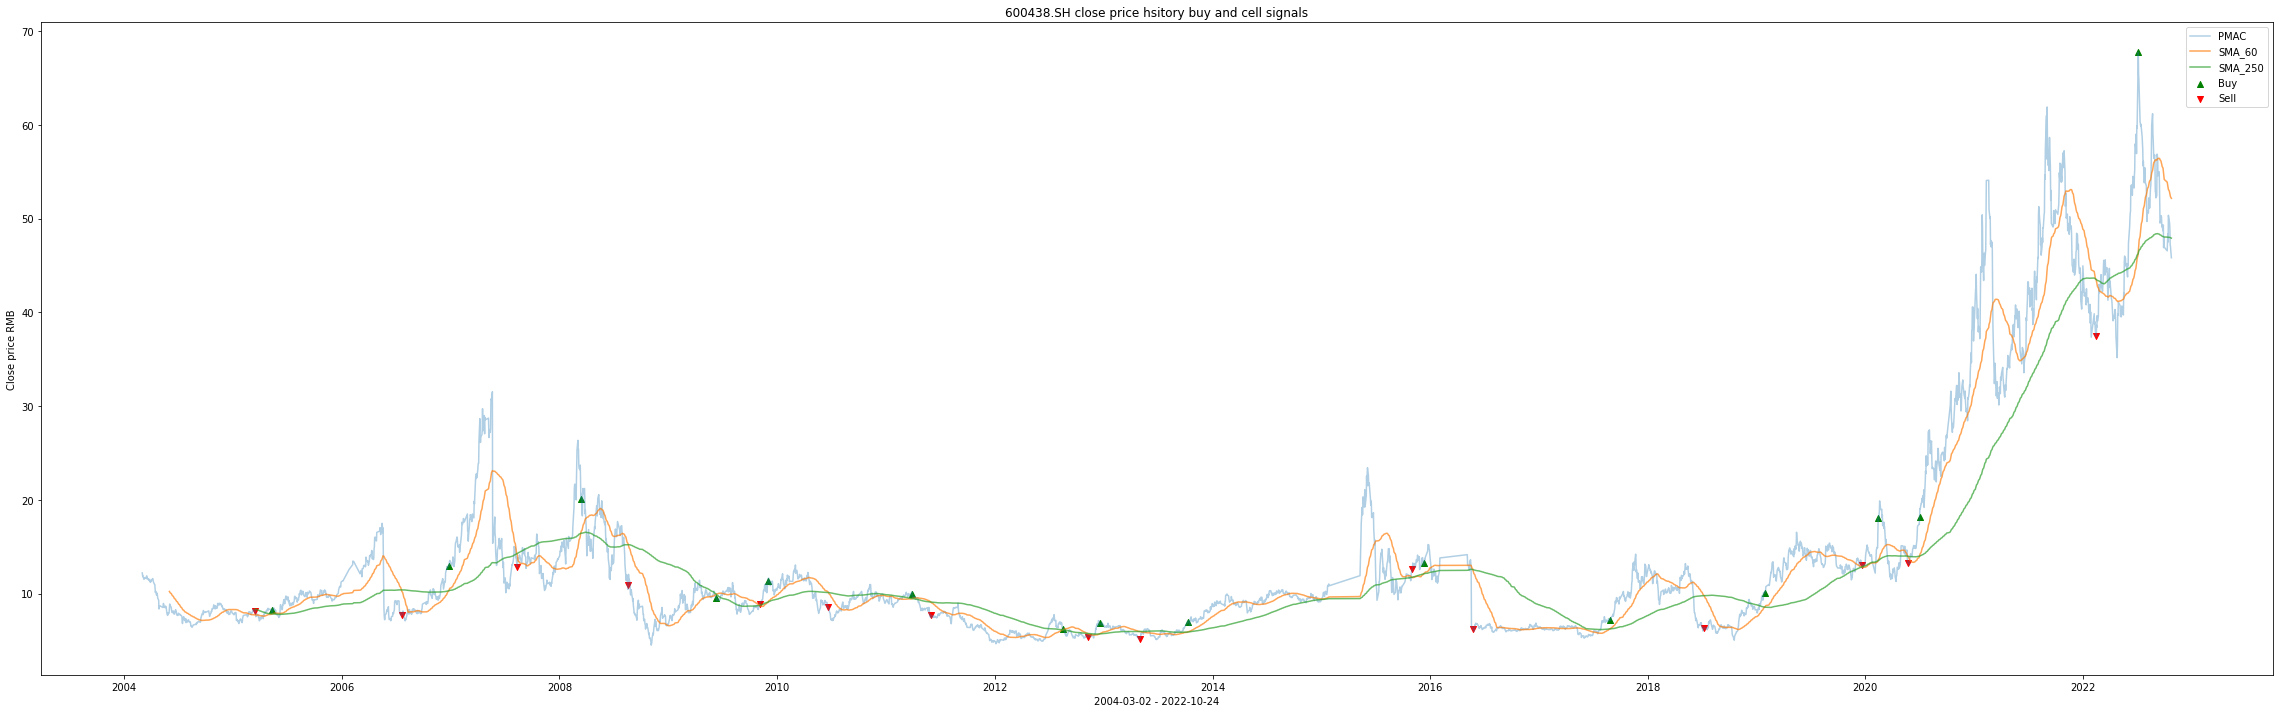

            buy_signal_price  sell_signal_price  trade_date
date                                                       
2022-07-05             67.75                NaN  2022-07-05
2022-02-14               NaN              37.45  2022-02-14
2020-07-01             18.17                NaN  2020-07-01
2020-05-22               NaN              13.31  2020-05-22
2020-02-13             18.03                NaN  2020-02-13
2019-12-20               NaN              13.09  2019-12-20
2019-01-29             10.10                NaN  2019-01-29
2018-07-10               NaN               6.31  2018-07-10
2017-08-28              7.14                NaN  2017-08-28
2016-05-24               NaN               6.19  2016-05-24
2015-12-11             13.23                NaN  2015-12-11
2015-11-02               NaN              12.67  2015-11-02
2013-10-09              7.03                NaN  2013-10-09
2013-05-03               NaN               5.21  2013-05-03
2012-12-18              6.89            

In [202]:
# https://tushare.pro/document/2?doc_id=25
# https://tushare.pro/document/2?doc_id=27

data = pro.stock_basic(list_status='L',
                       fields='ts_code,symbol,name,area,industry,list_date')

start_date = '200211024'
end_date = '20221024'

ts_data = [
    ['300750.SZ', '宁德时代', 5, 10, 0, 'Lithium Battery　リチウム電池'],
    ['300750.SZ', '宁德时代', 20, 60, 0, 'Lithium Battery　リチウム電池'],
    ['300750.SZ', '宁德时代', 30, 120, 0, 'Lithium Battery　リチウム電池'],
    ['300750.SZ', '宁德时代', 60, 250, 0, 'Lithium Battery　リチウム電池'],
    ['600519.SH', '贵州茅台', 5, 10, 0, 'Wine 酒'],
    ['600519.SH', '贵州茅台', 20, 60, 0, 'Wine 酒'],
    ['600519.SH', '贵州茅台', 30, 120, 0, 'Wine 酒'],
    ['600519.SH', '贵州茅台', 60, 250, 0, 'Wine 酒'],
    ['603501.SH', '韦尔股份', 5, 10, 0, 'Semiconductors 半導体'],
    ['603501.SH', '韦尔股份', 20, 60, 0, 'Semiconductors 半導体'],
    ['603501.SH', '韦尔股份', 30, 120, 0, 'Semiconductors 半導体'],
    ['603501.SH', '韦尔股份', 60, 250, 0, 'Semiconductors 半導体'],
    ['603259.SH', '药明康德', 5, 10, 0, 'Pharmaceutical 医薬'],
    ['603259.SH', '药明康德', 20, 60, 0, 'Pharmaceutical 医薬'],
    ['603259.SH', '药明康德', 30, 120, 0, 'Pharmaceutical 医薬'],
    ['603259.SH', '药明康德', 60, 250, 0, 'Pharmaceutical 医薬'],
    ['300413.SZ', '芒果超媒', 5, 10, 0, 'New media'],
    ['300413.SZ', '芒果超媒', 20, 60, 0, 'New media'],
    ['300413.SZ', '芒果超媒', 30, 120, 0, 'New media'],
    ['300413.SZ', '芒果超媒', 60, 250, 0, 'New media'],
    ['600438.SH', '通威股份', 5, 10, 0, 'Photovoltaic 太陽光発電'],
    ['600438.SH', '通威股份', 20, 60, 0, 'Photovoltaic 太陽光発電'],
    ['600438.SH', '通威股份', 30, 120, 0, 'Photovoltaic 太陽光発電'],
    ['600438.SH', '通威股份', 60, 250, 0, 'Photovoltaic 太陽光発電'],
]

for index in range(len(ts_data)):
    ts_code = ts_data[index][0]
    name = ts_data[index][1]
    short_term_days = ts_data[index][2]
    long_term_days = ts_data[index][3]
    industry = ts_data[index][5]

    df = pro.daily(ts_code=ts_code,
                   start_date=start_date, end_date=end_date).drop(columns=[
                       'low', 'high', 'pre_close', 'ts_code', 'change', 'vol', 'pct_chg', 'amount'])

    earnings_percent = graph_chart(
        df, name, ts_code, short_term_days, long_term_days)
    ts_data[index][4] = earnings_percent
    print('earnings: ' + earnings_percent)
    print('data length: ' + str(len(df)))


result_df = pd.DataFrame(ts_data, columns=['stock_code', 'stock_name', 'industry',
                         'short_term_days', 'long_term_days', 'earnings_percent'])
print(result_df)
